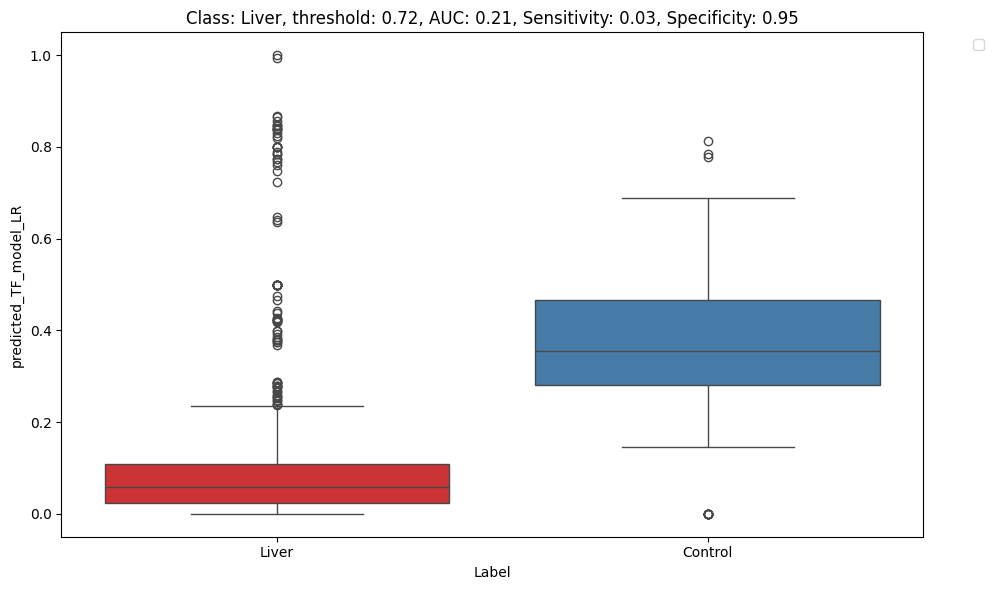

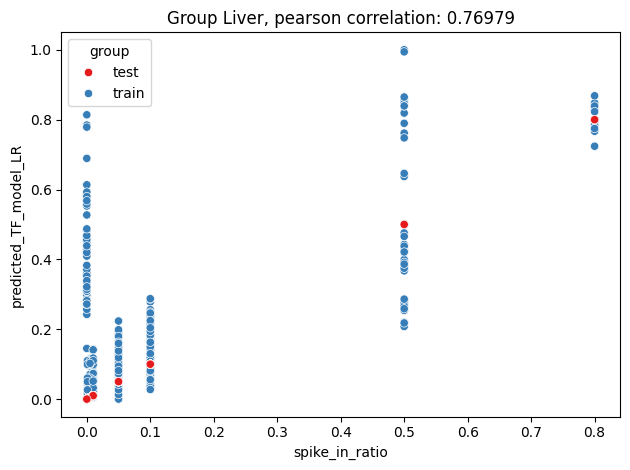

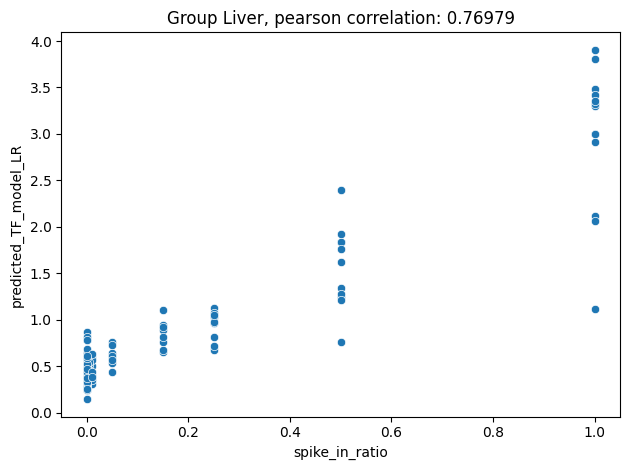

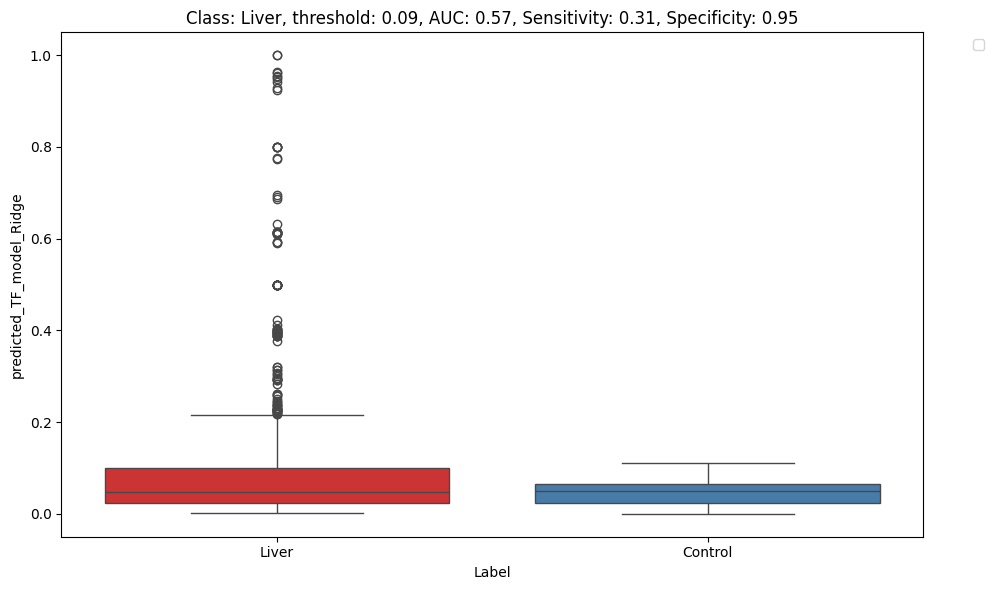

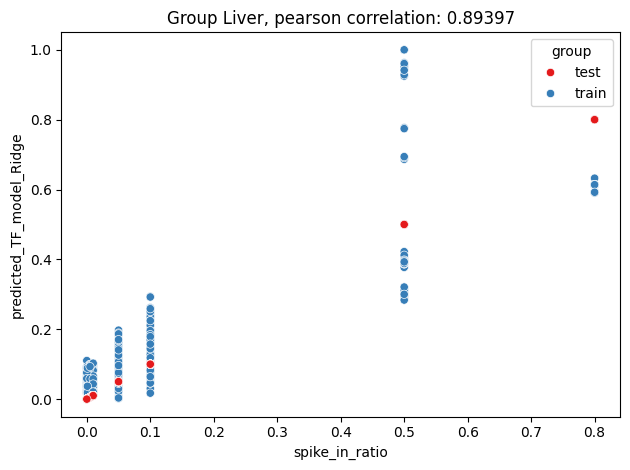

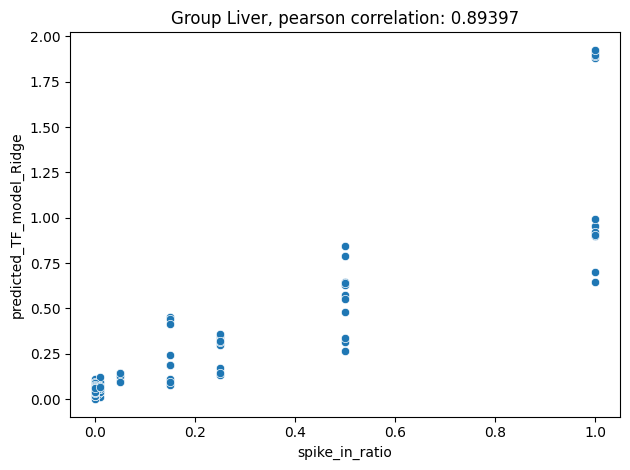

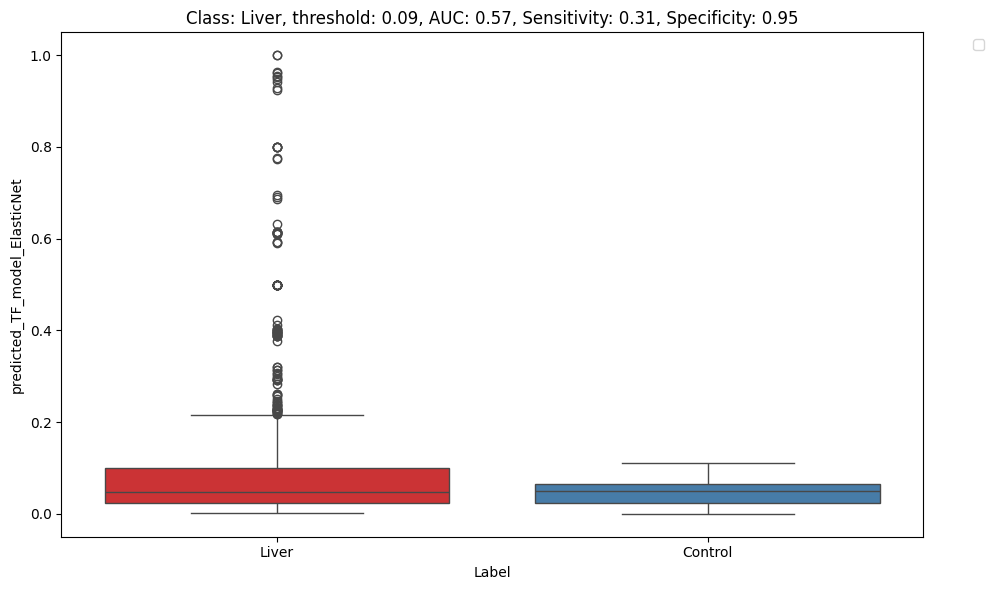

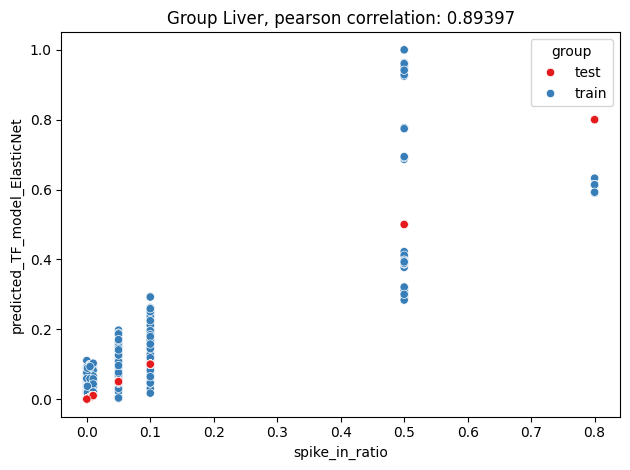

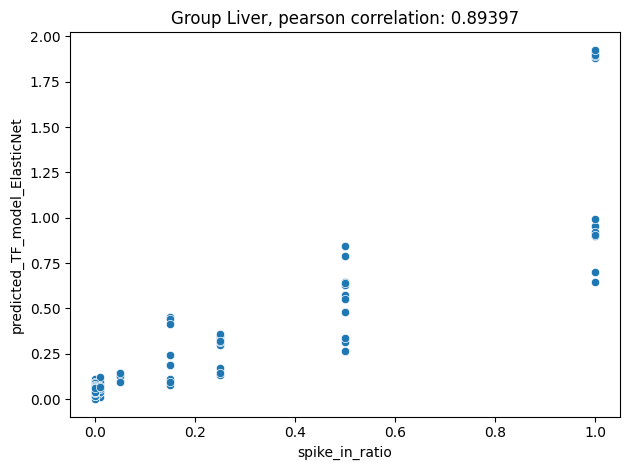

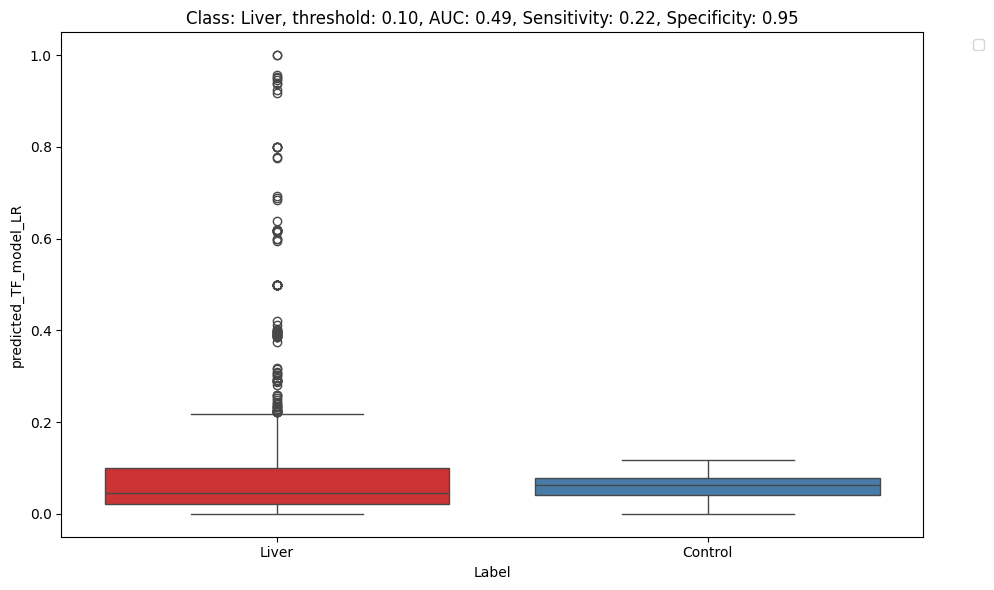

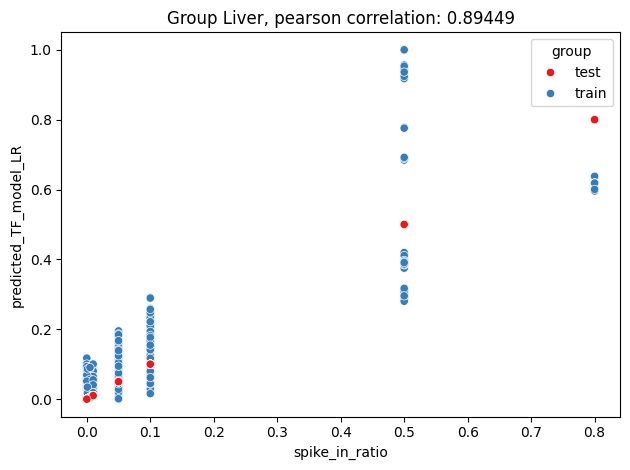

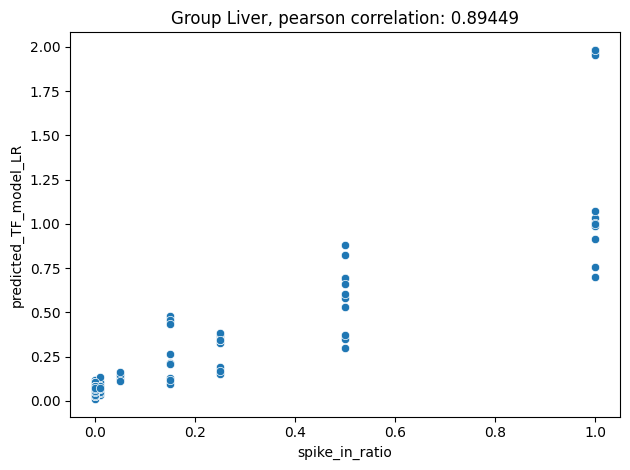

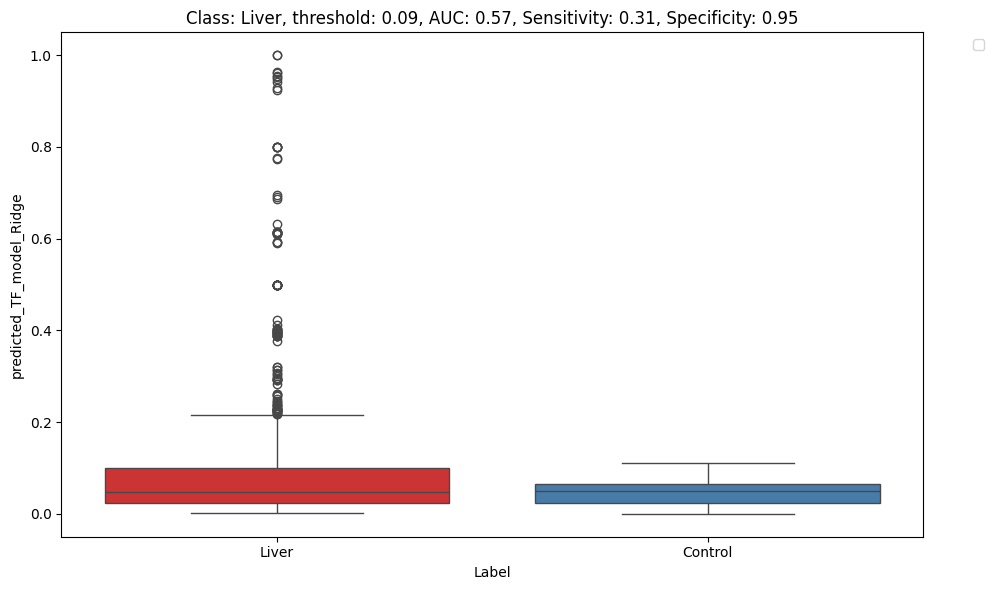

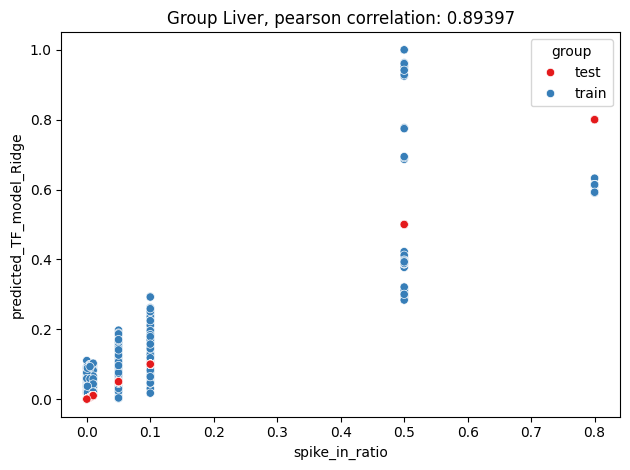

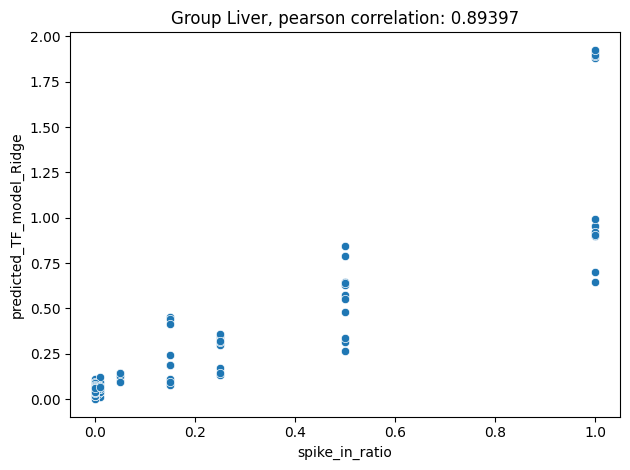

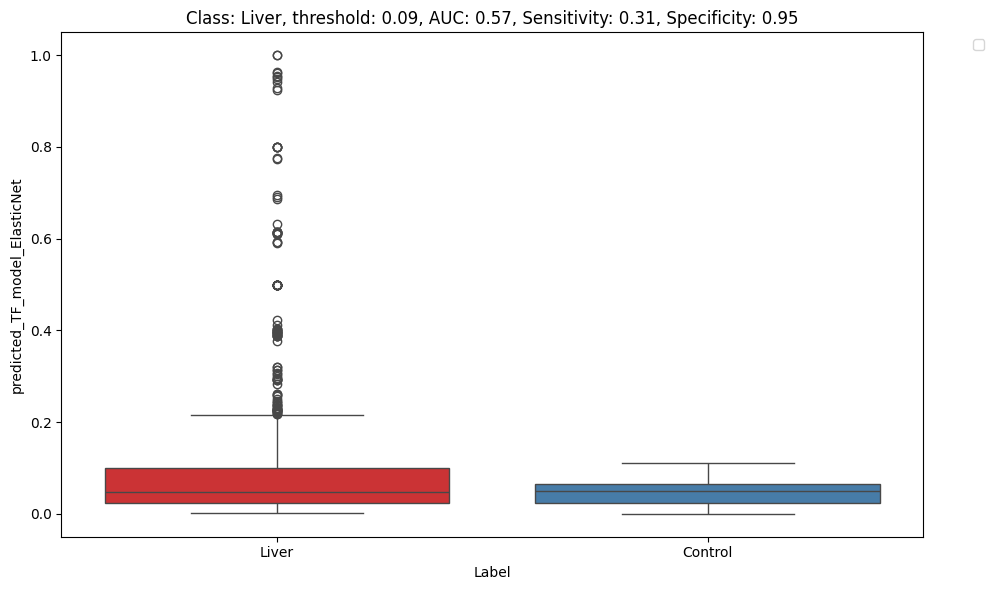

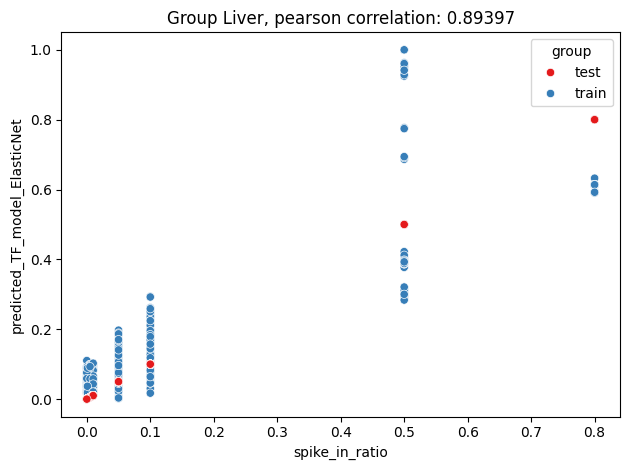

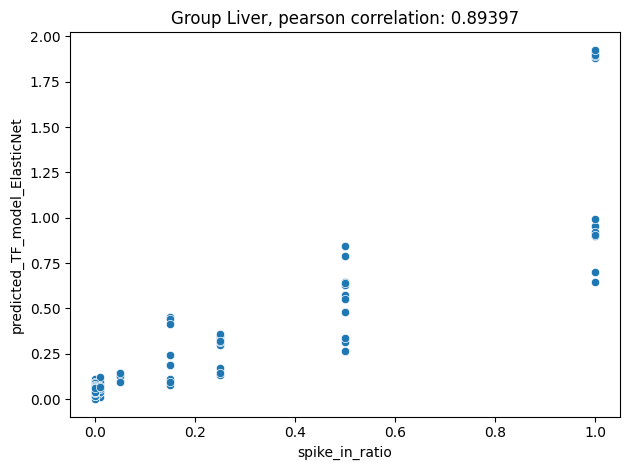

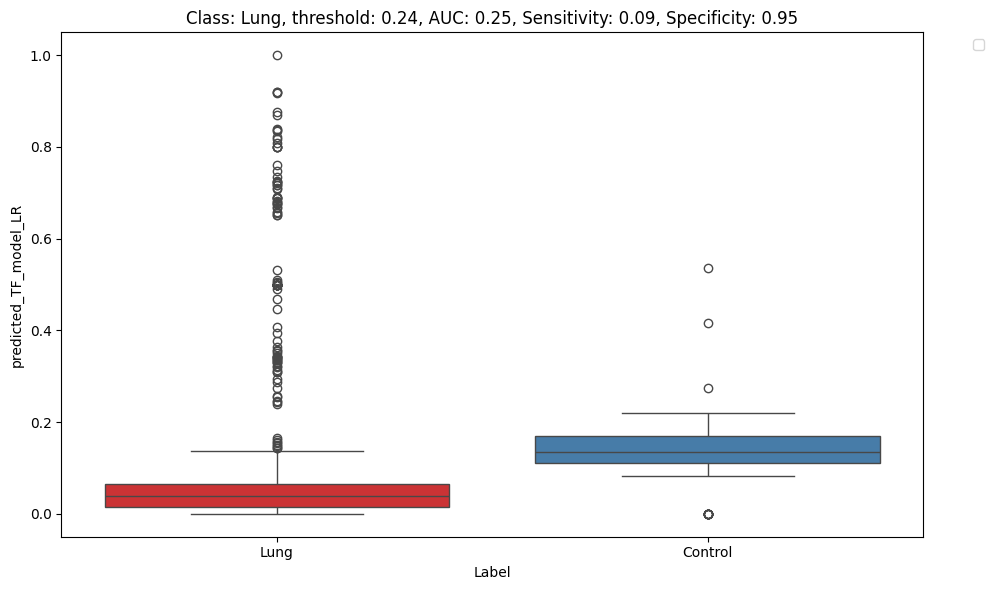

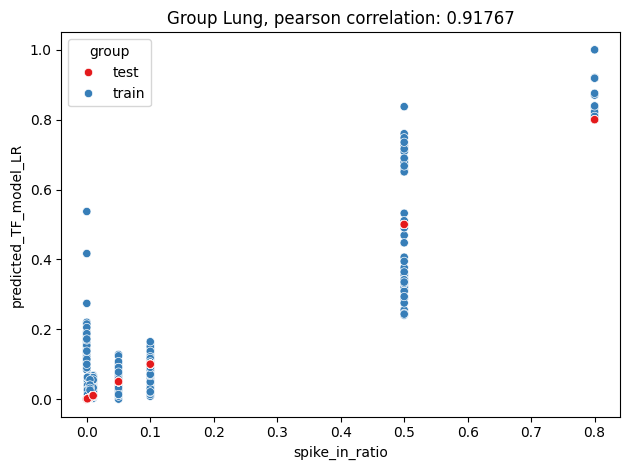

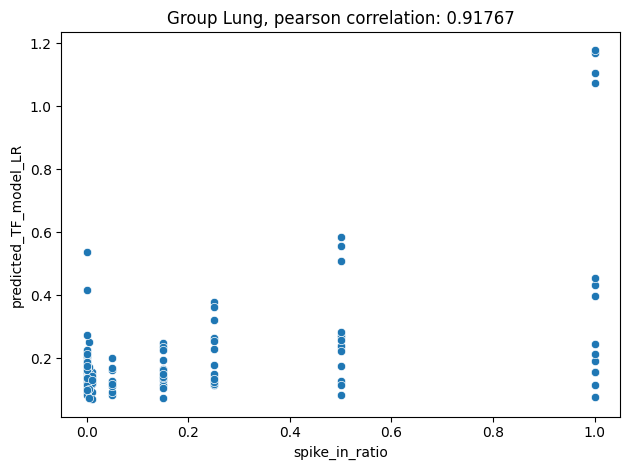

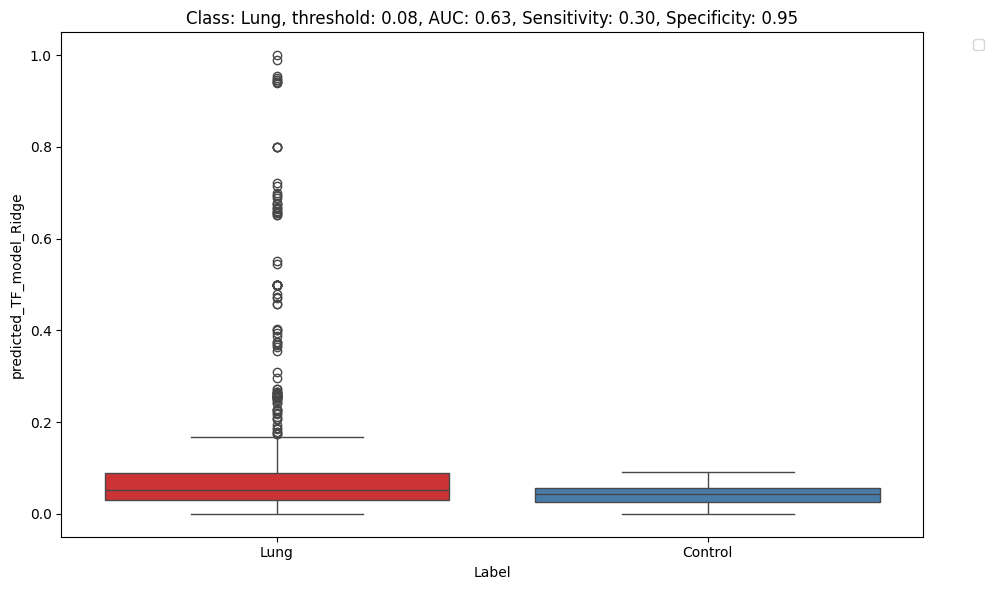

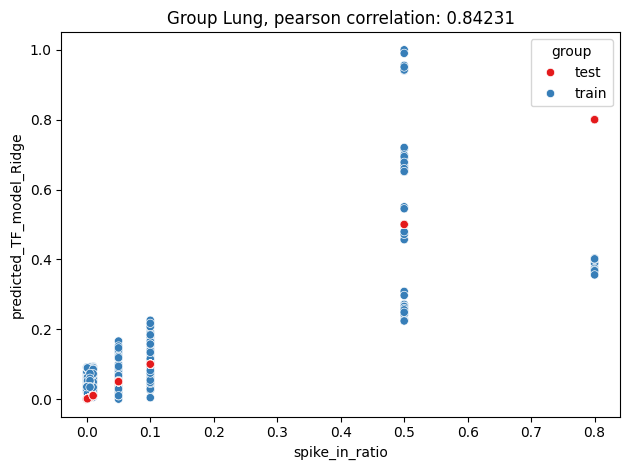

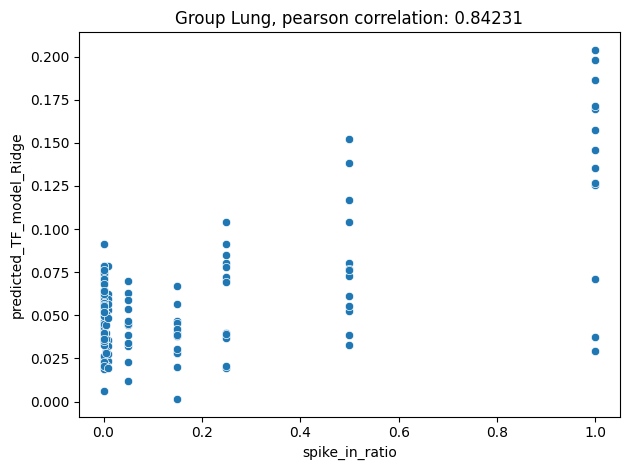

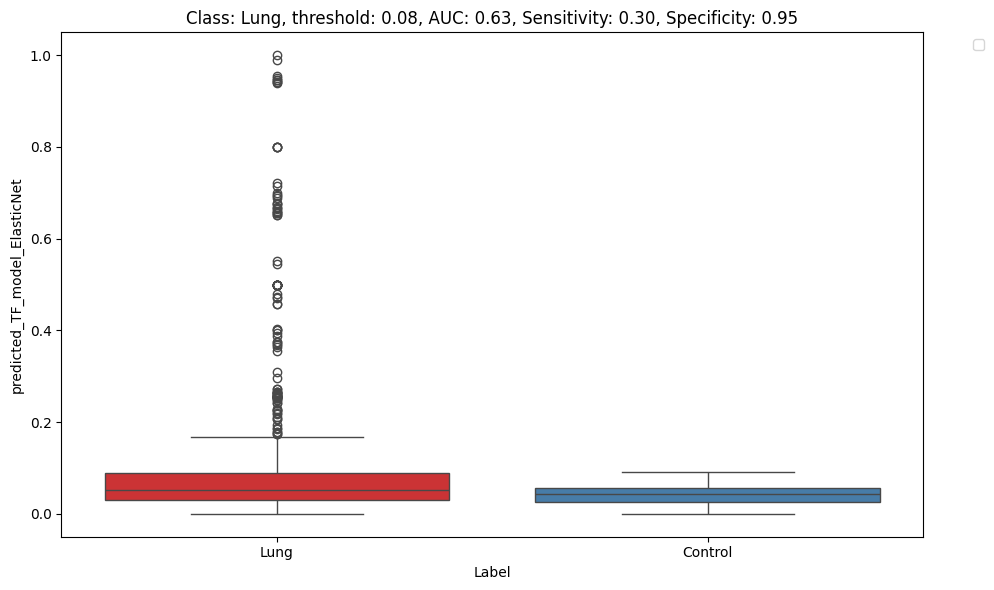

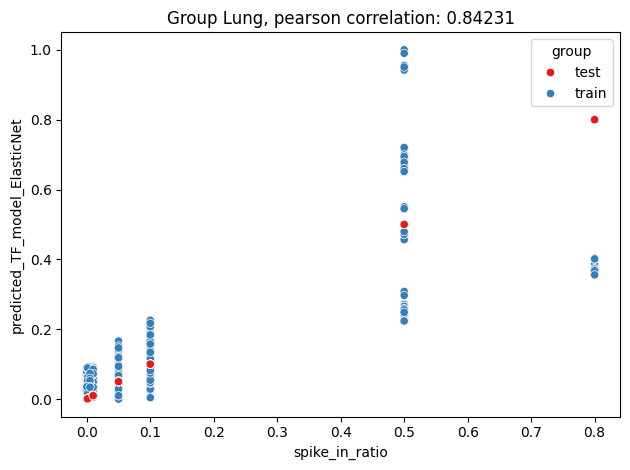

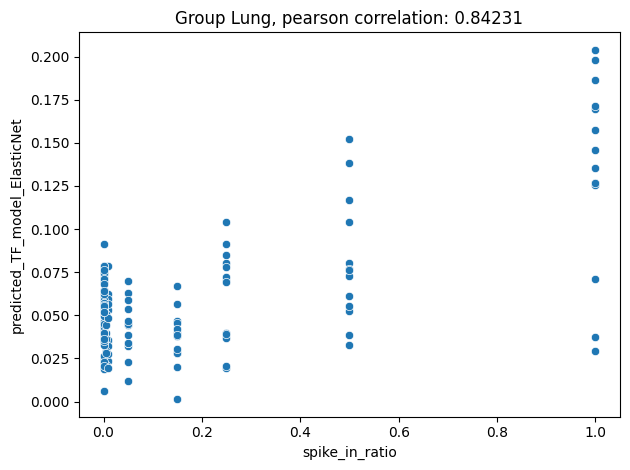

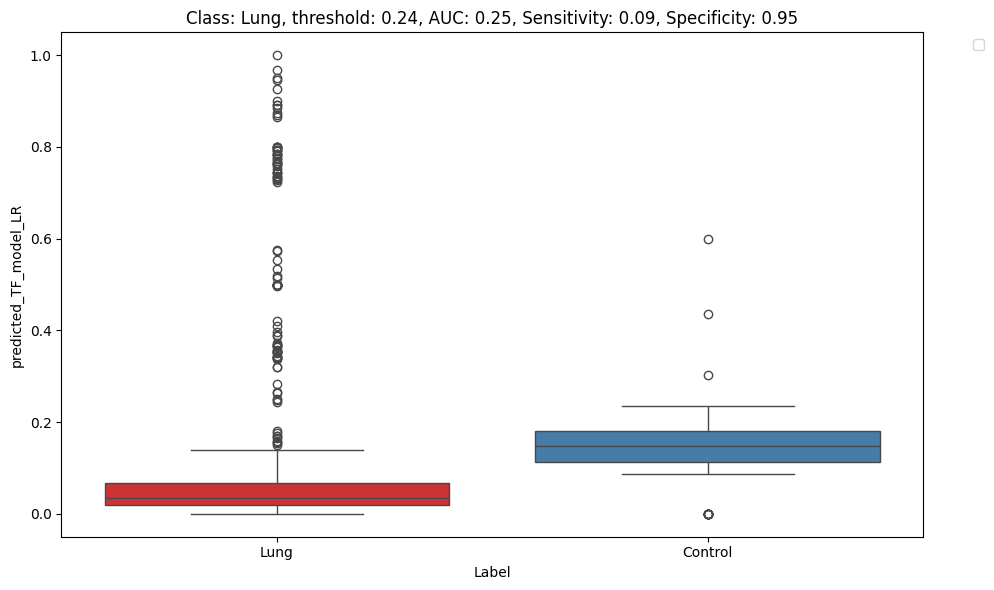

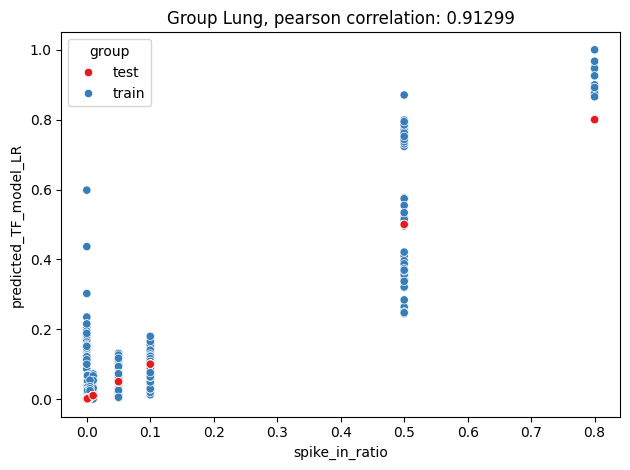

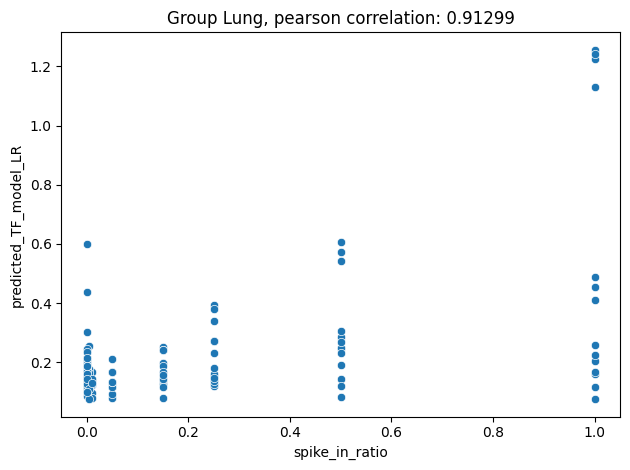

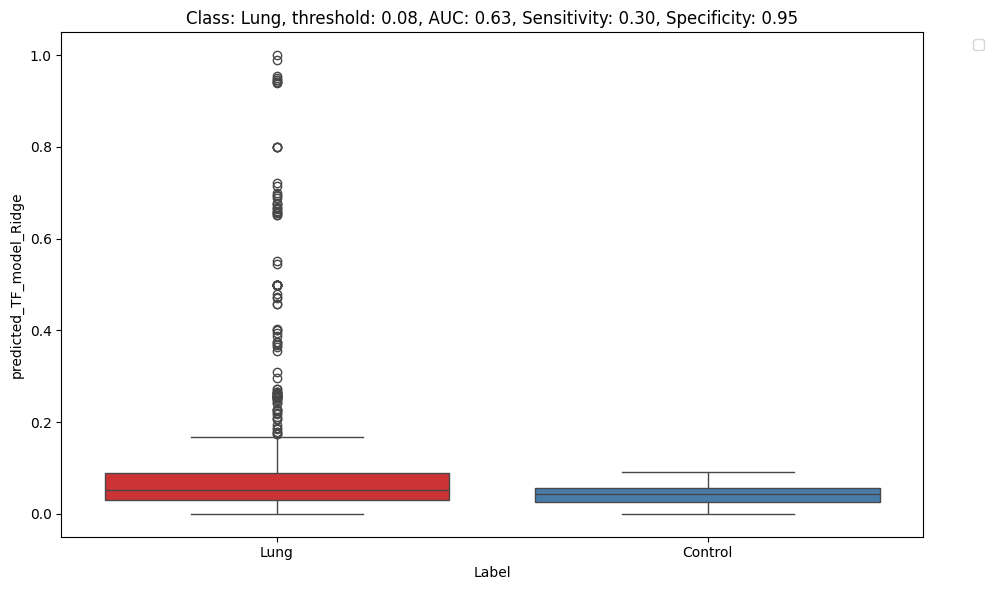

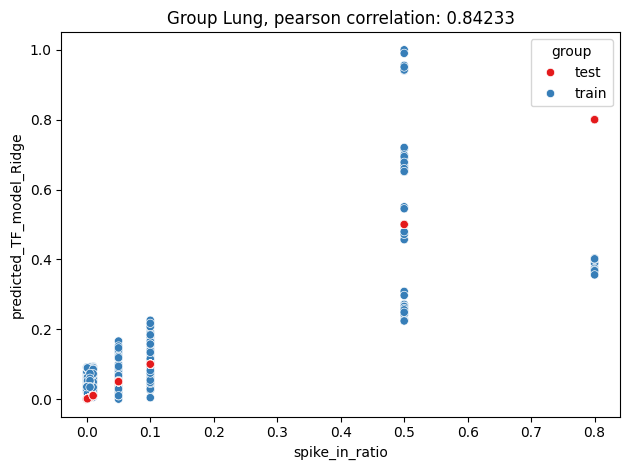

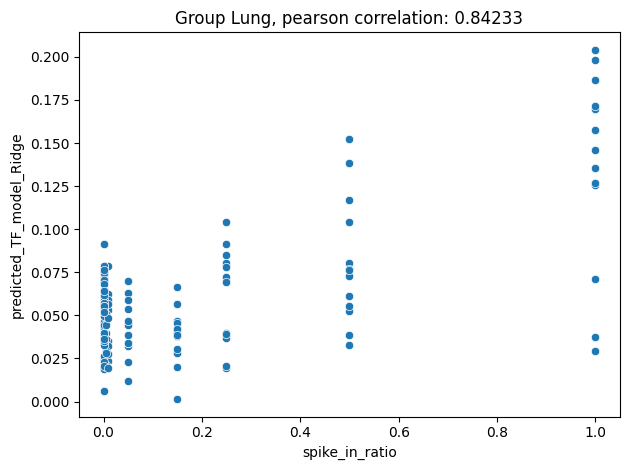

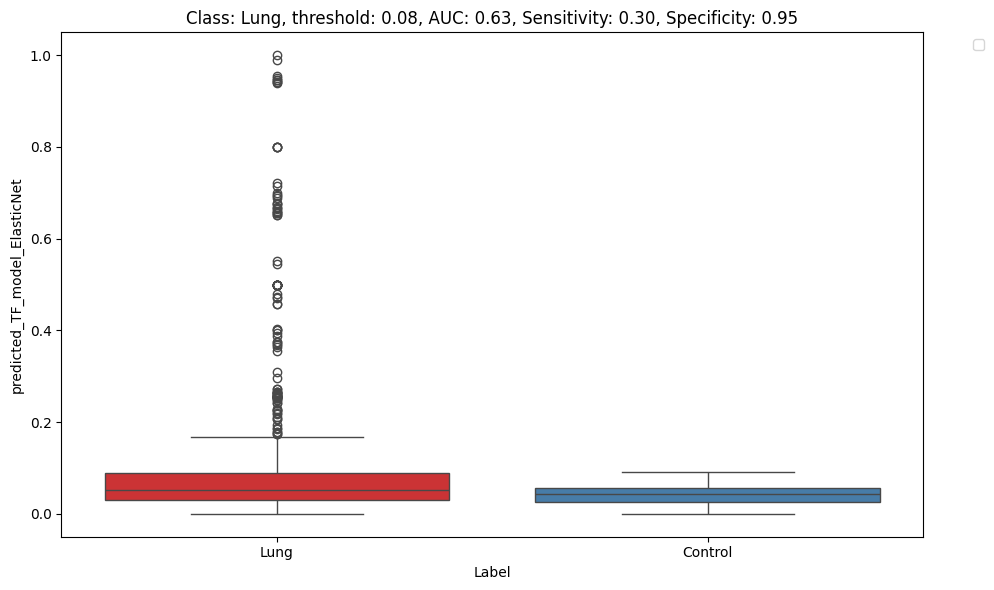

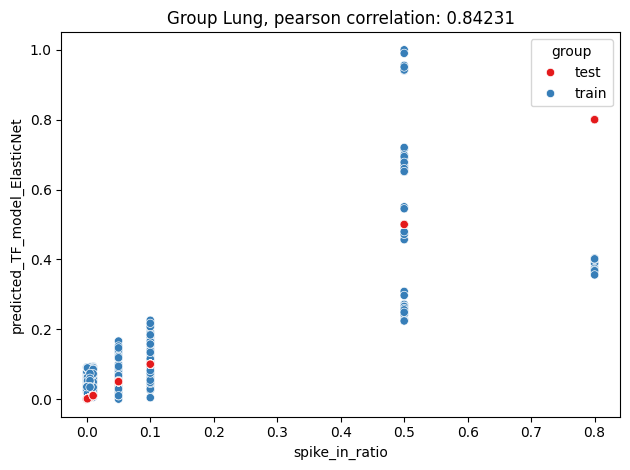

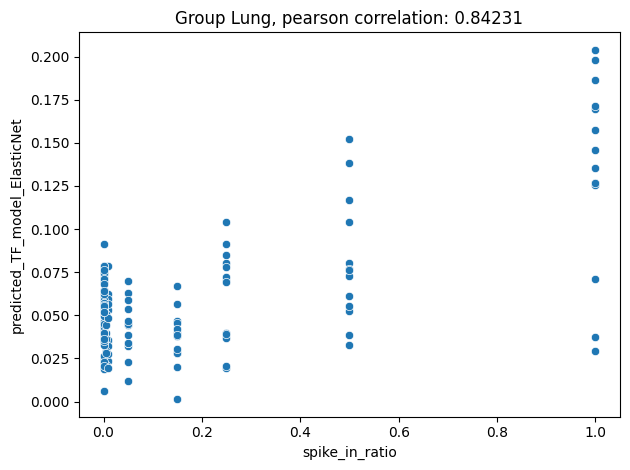

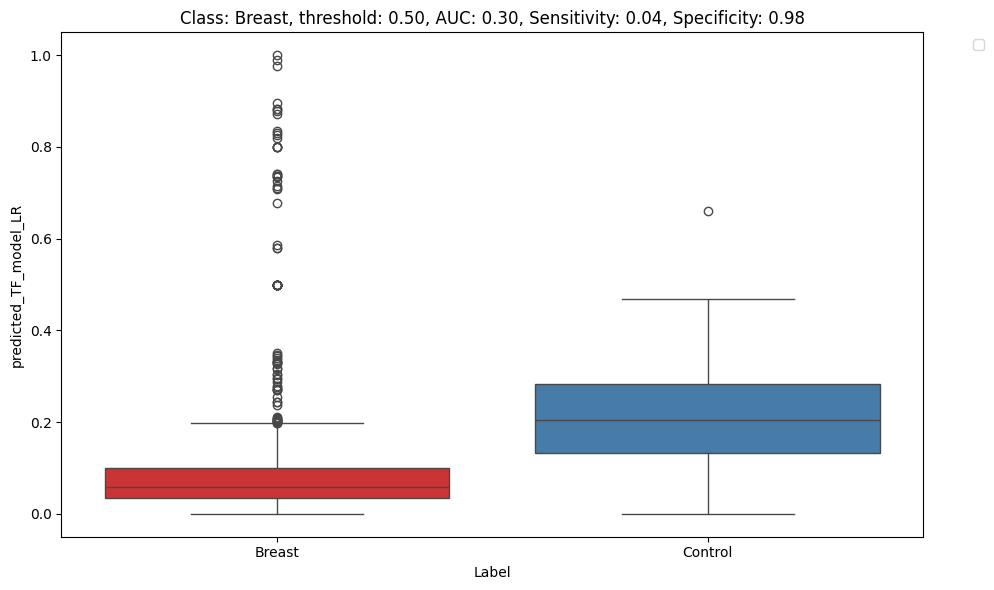

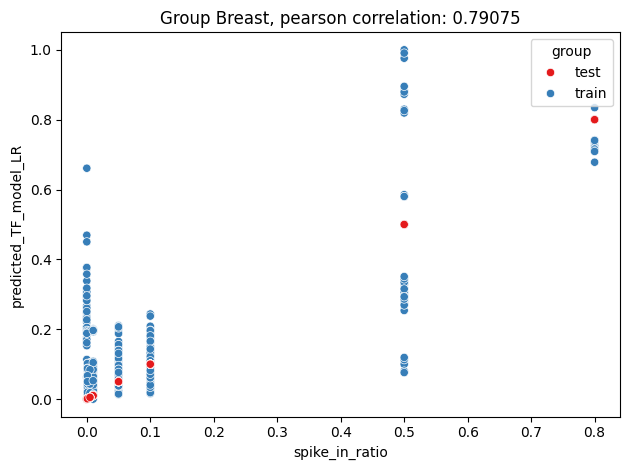

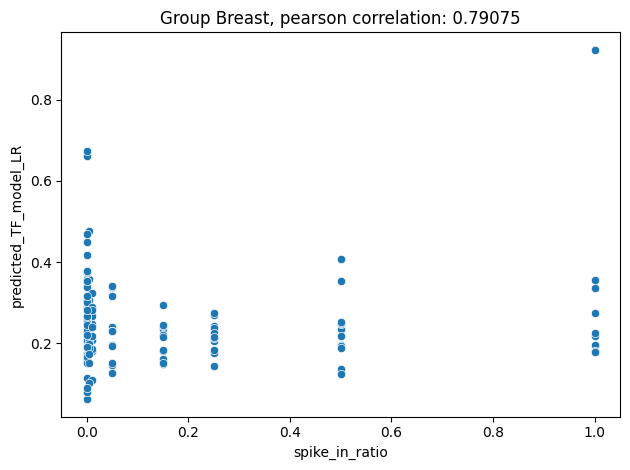

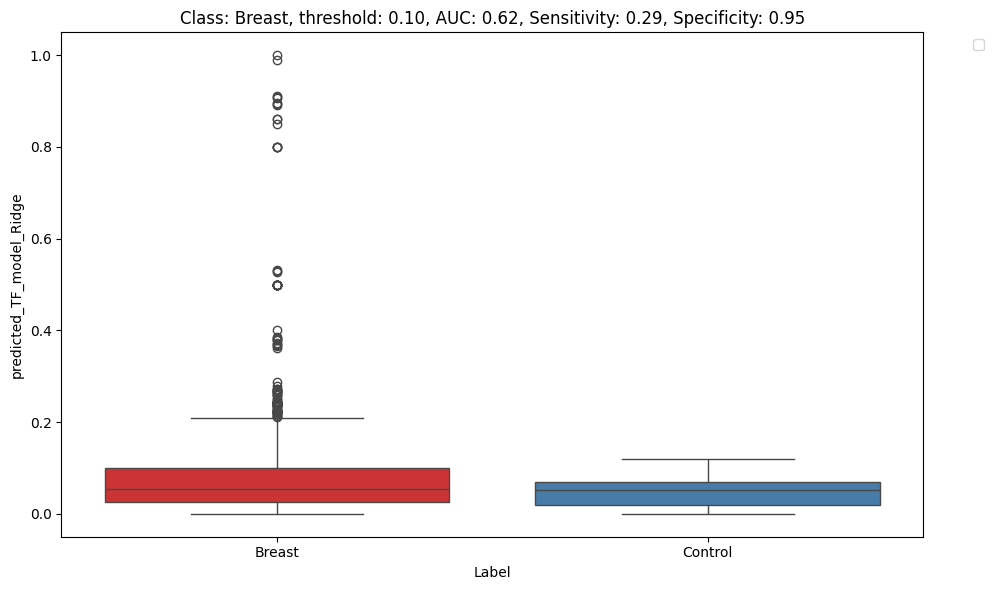

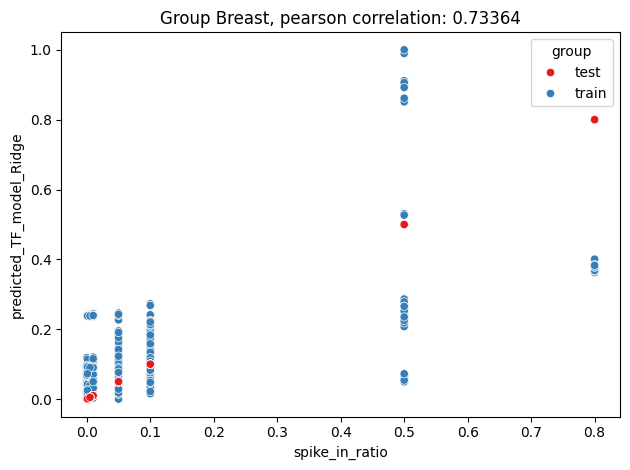

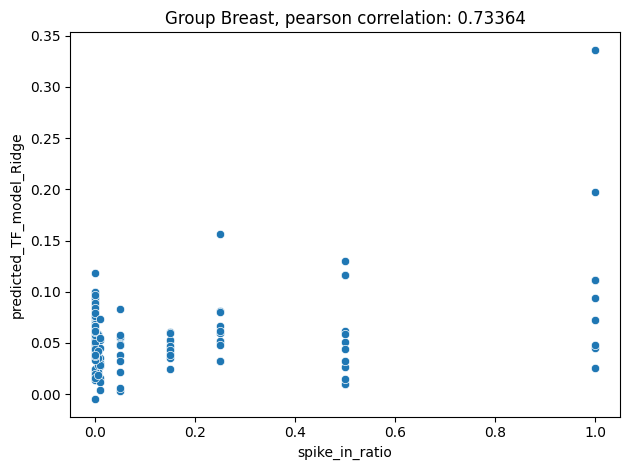

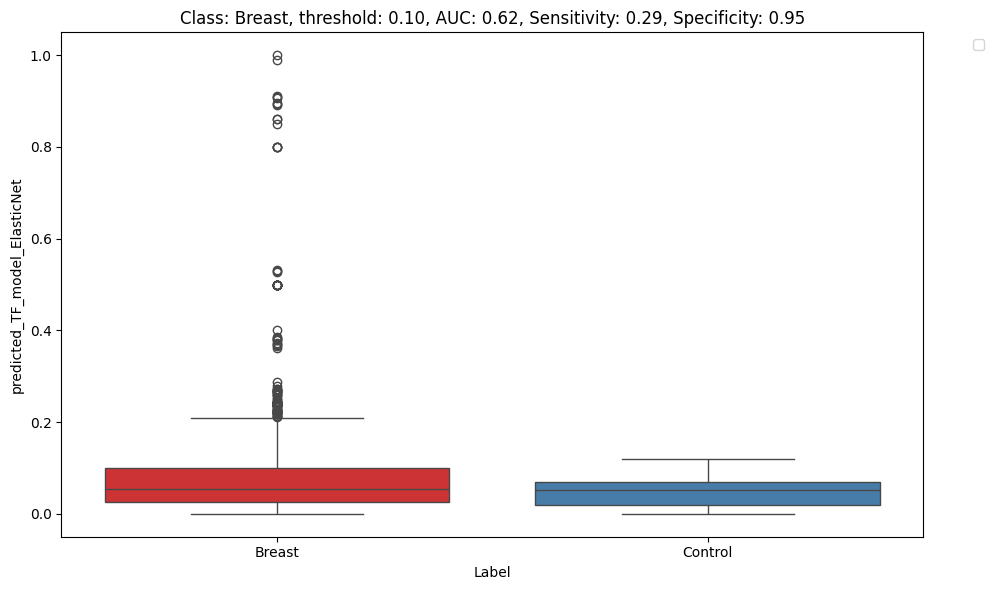

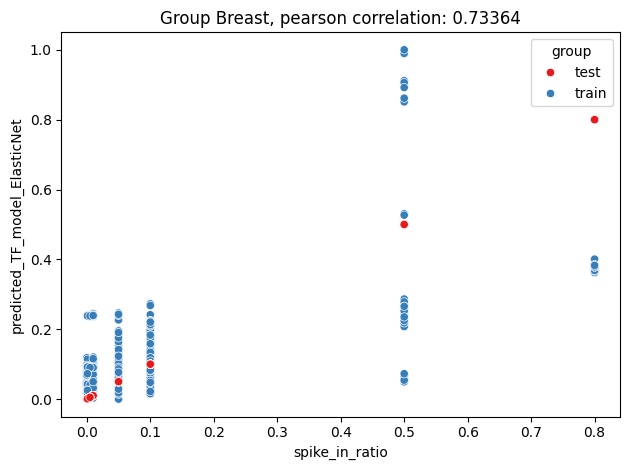

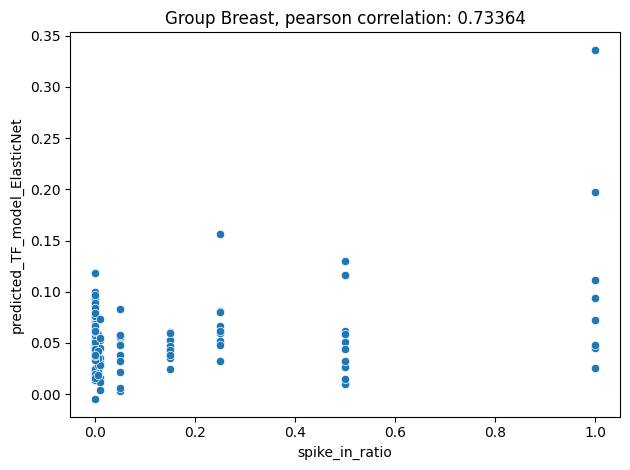

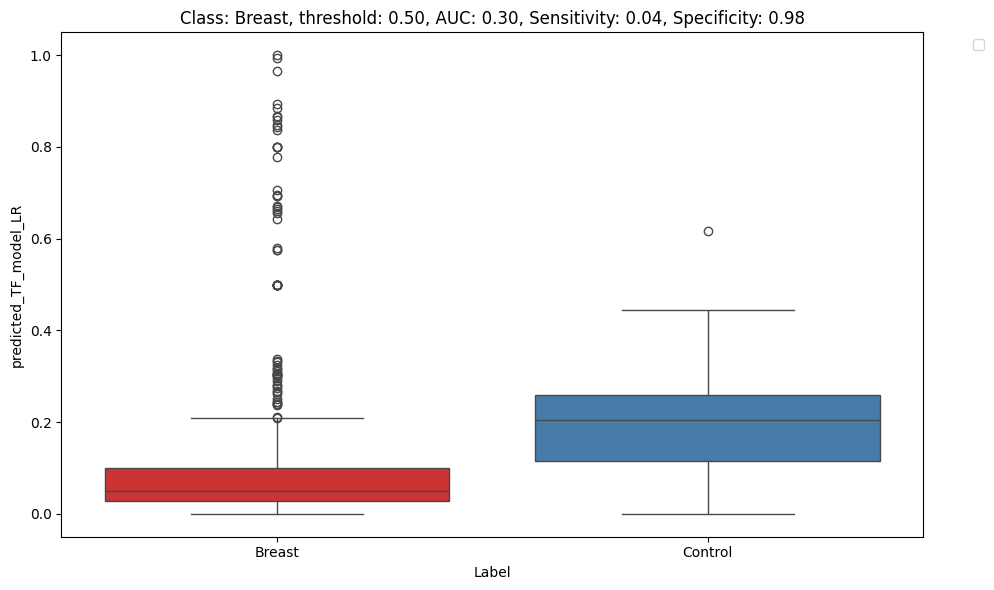

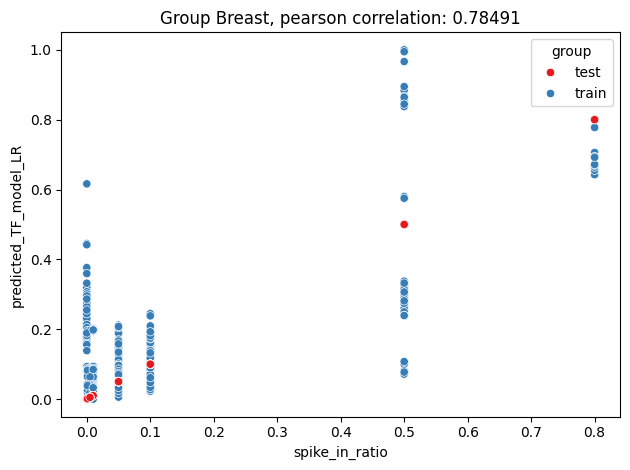

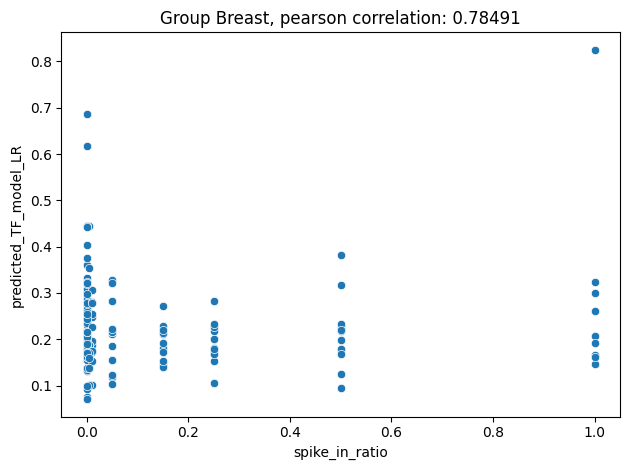

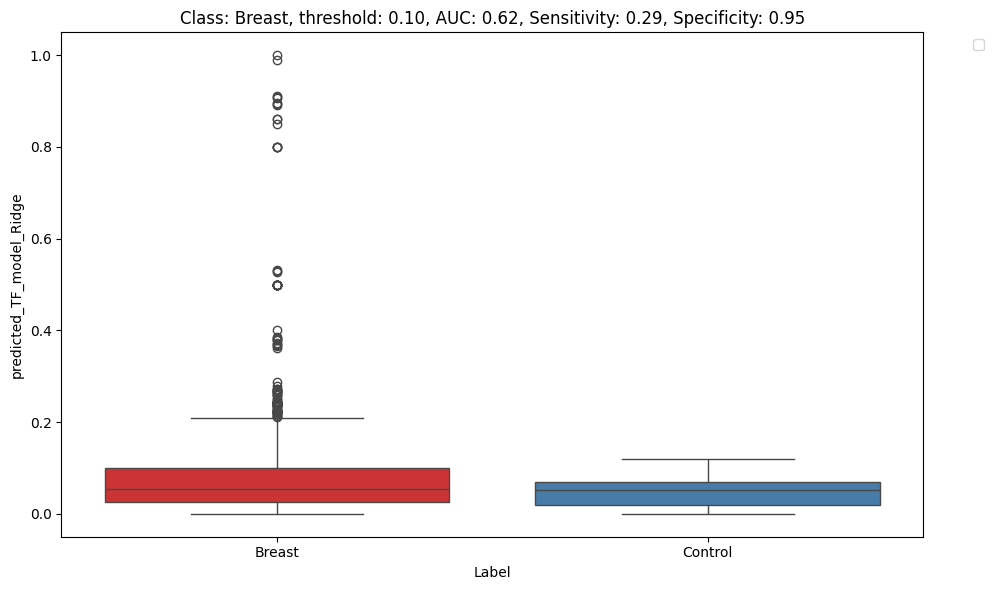

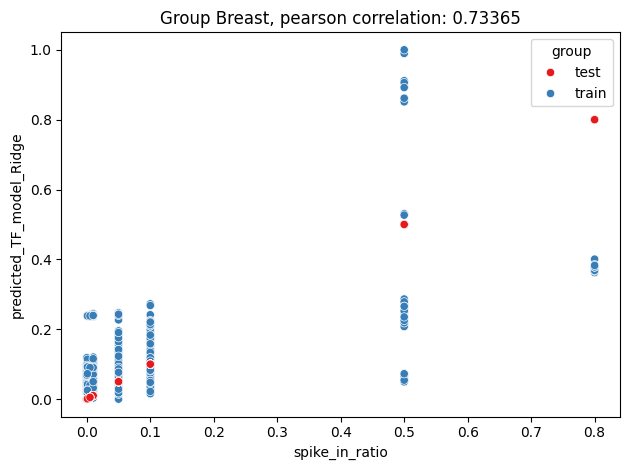

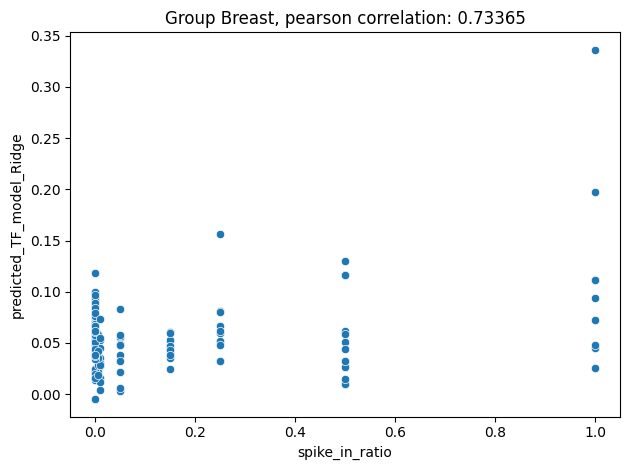

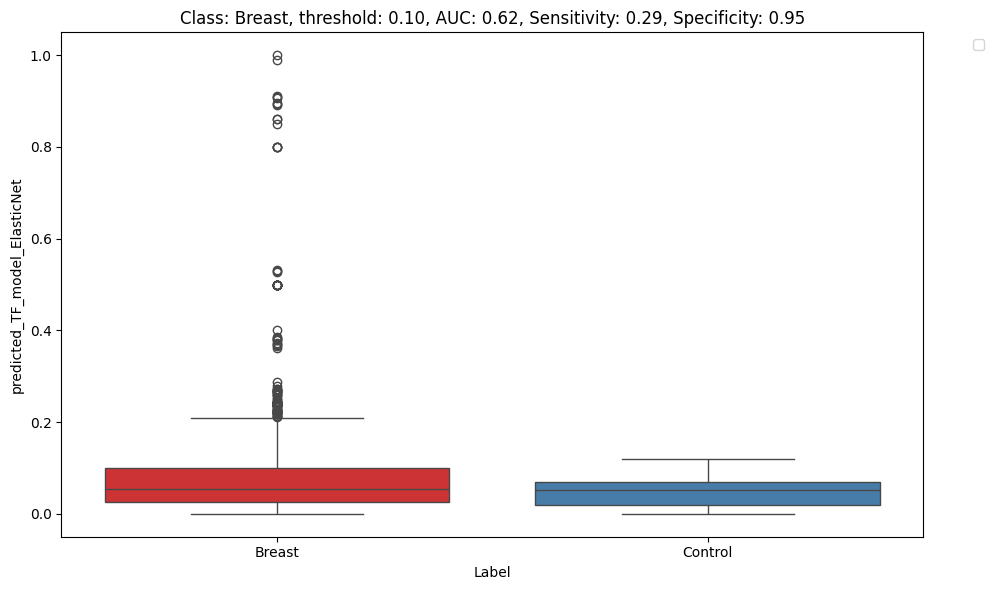

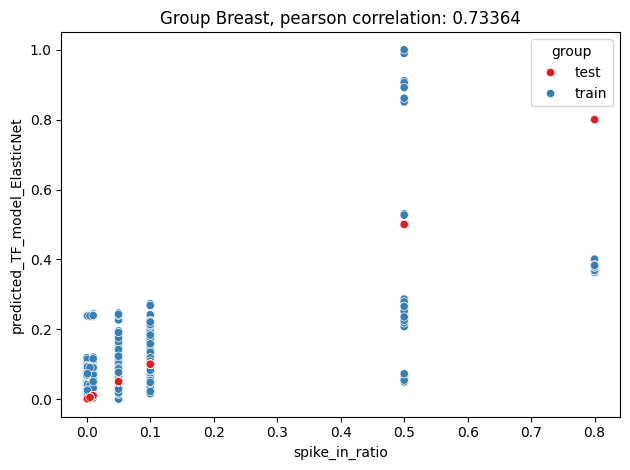

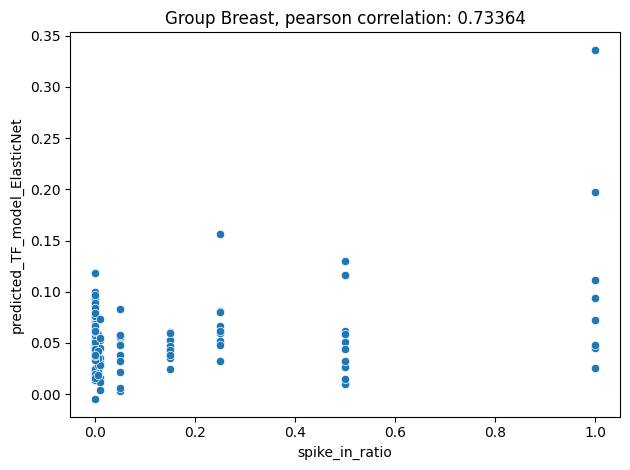

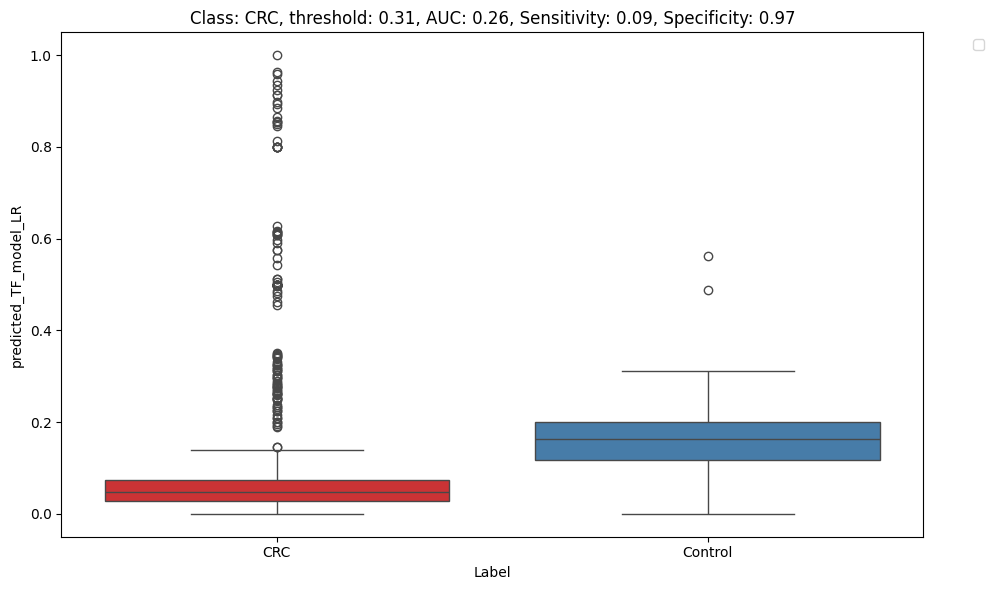

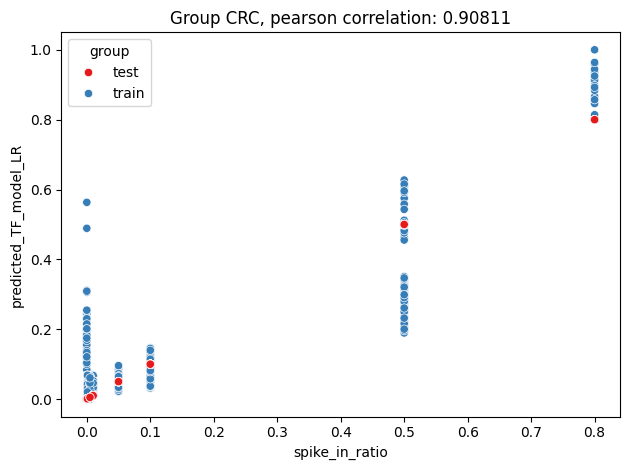

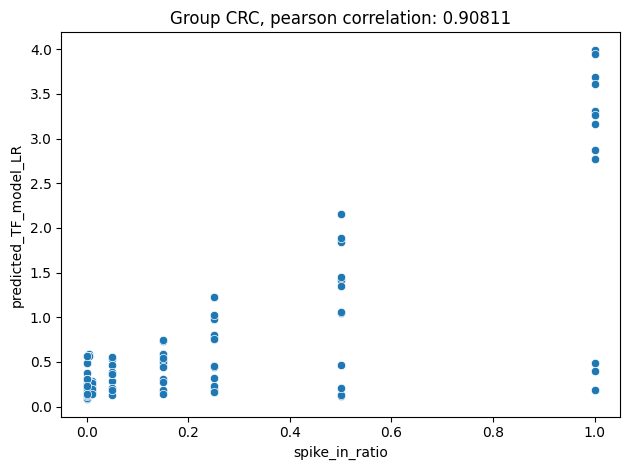

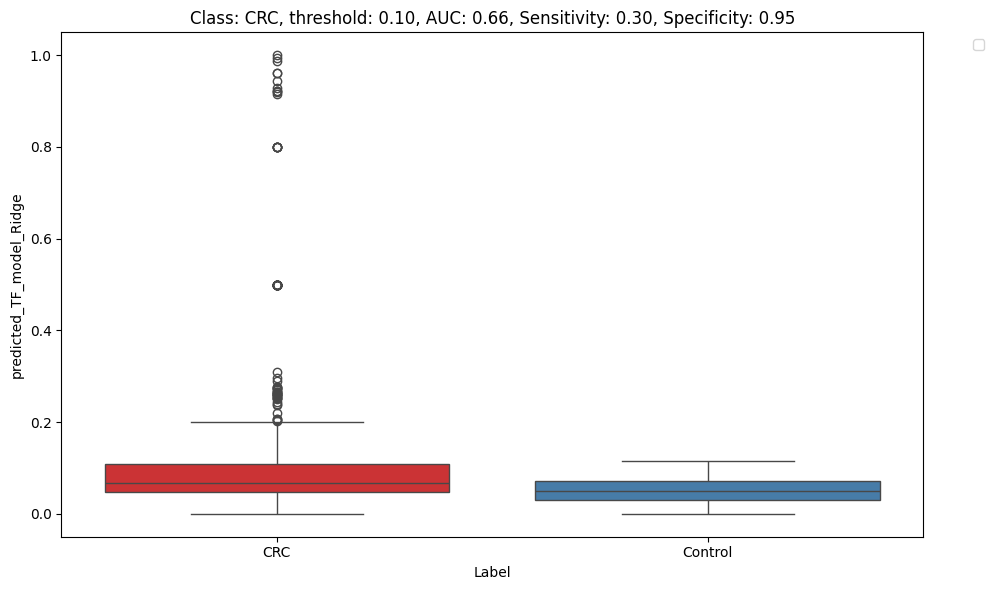

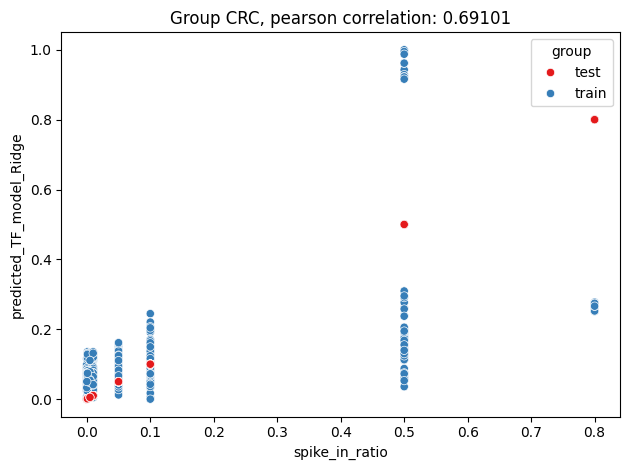

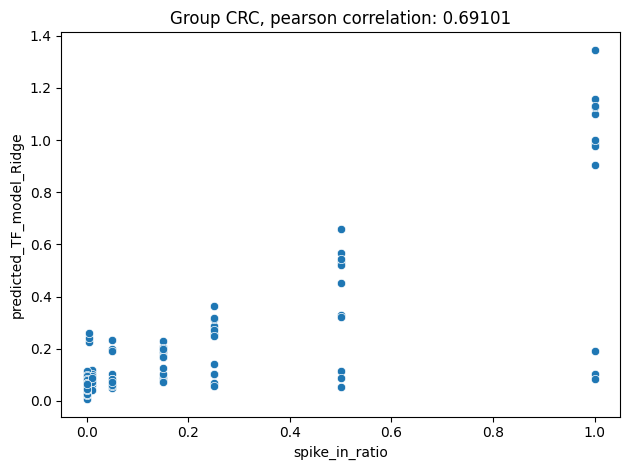

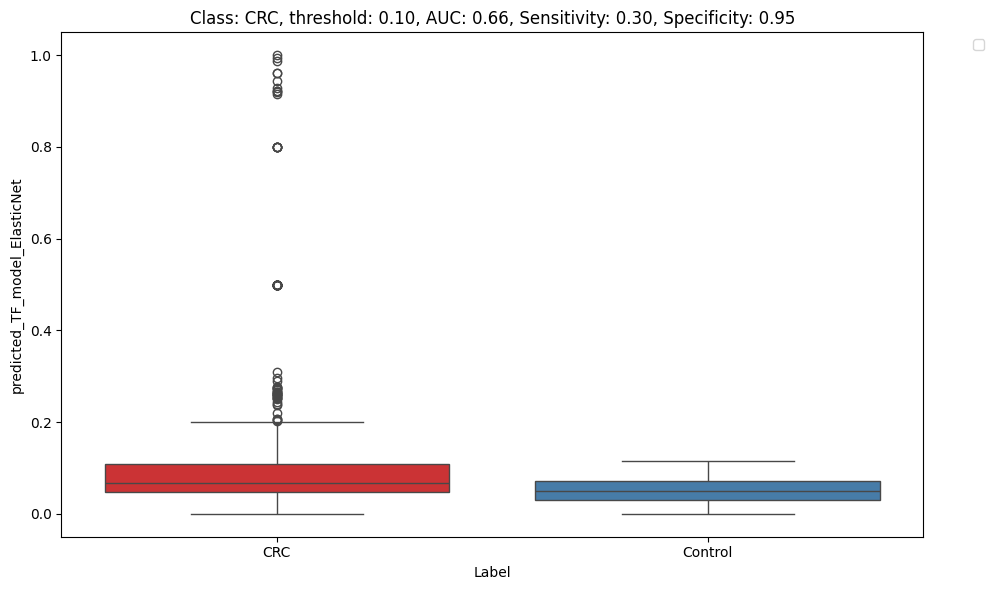

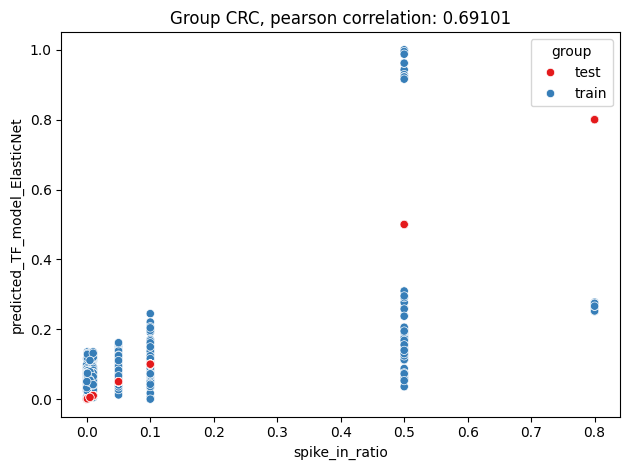

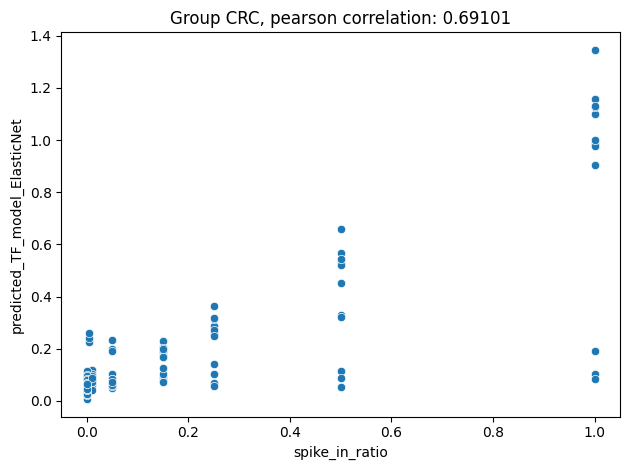

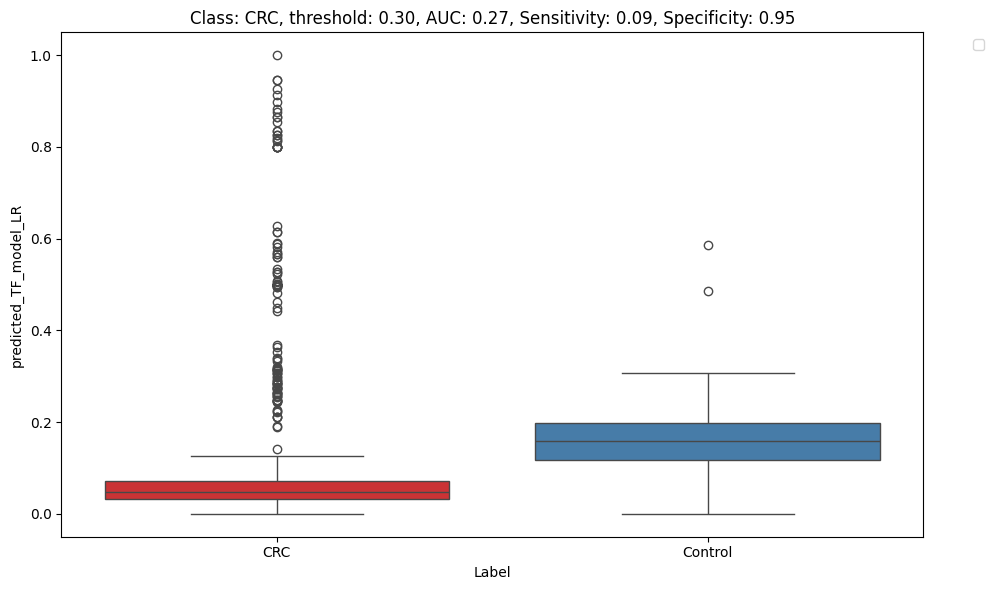

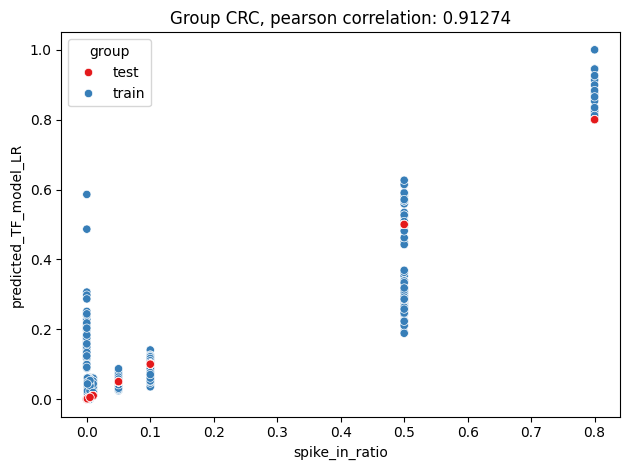

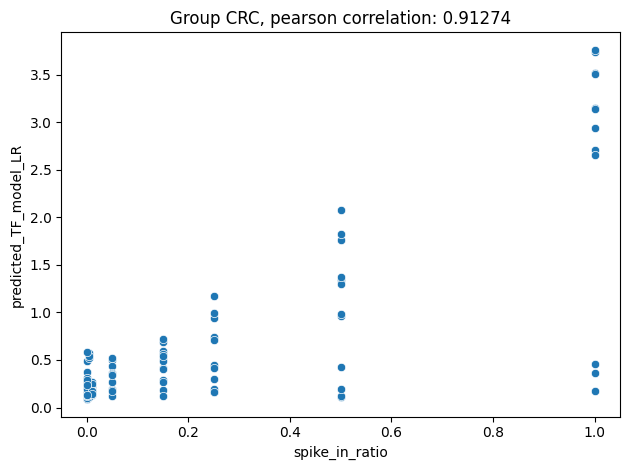

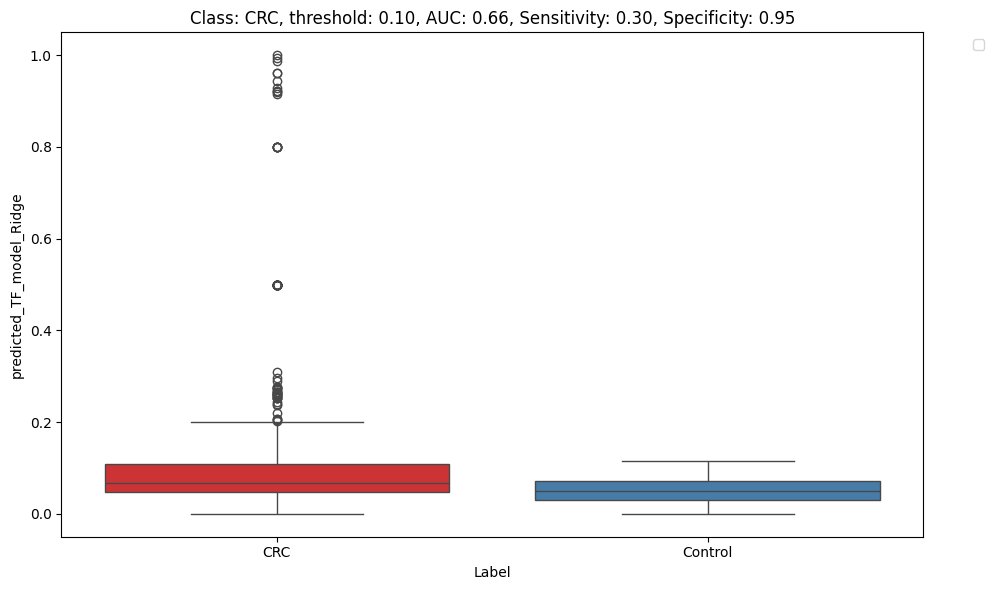

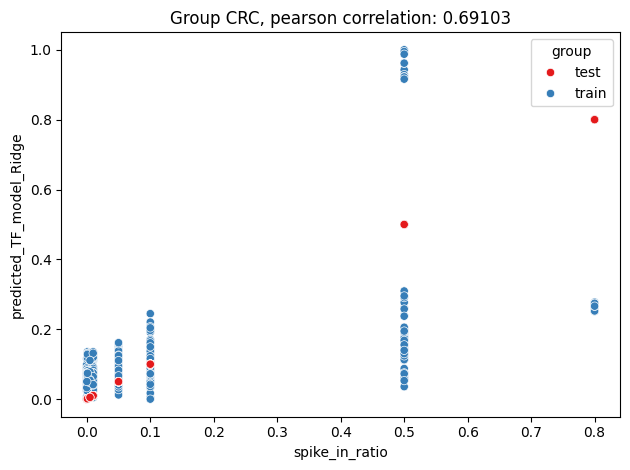

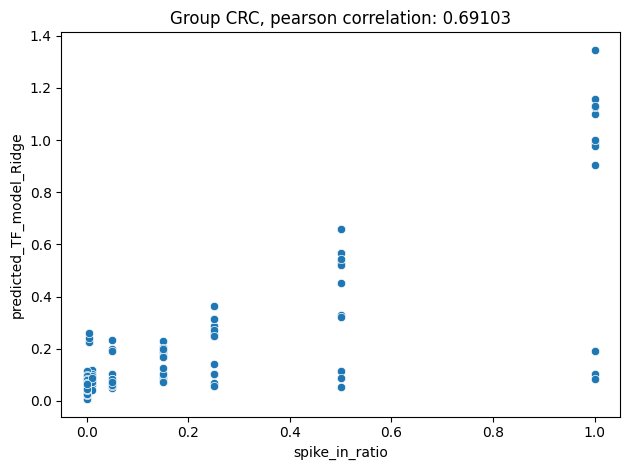

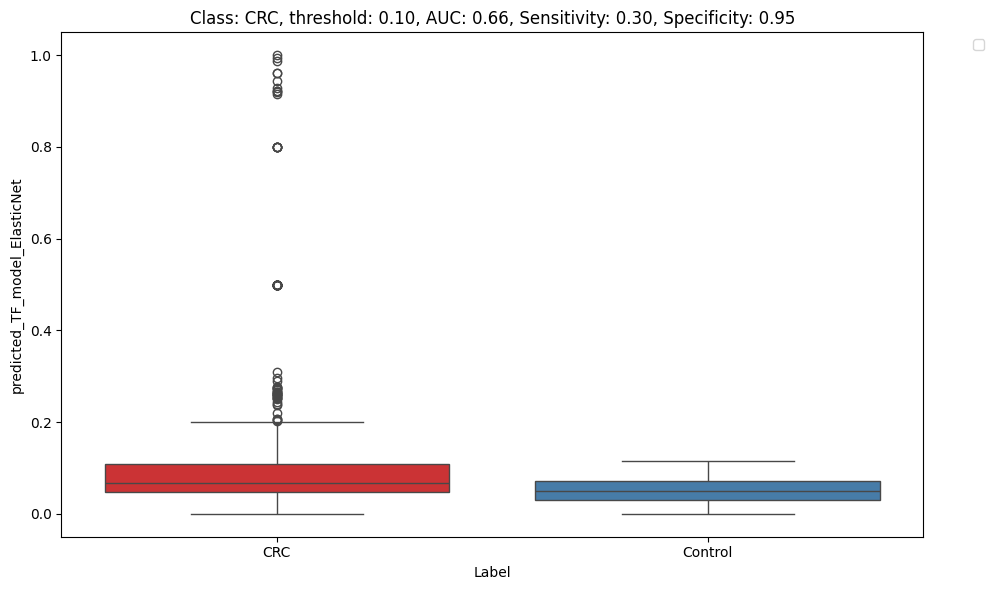

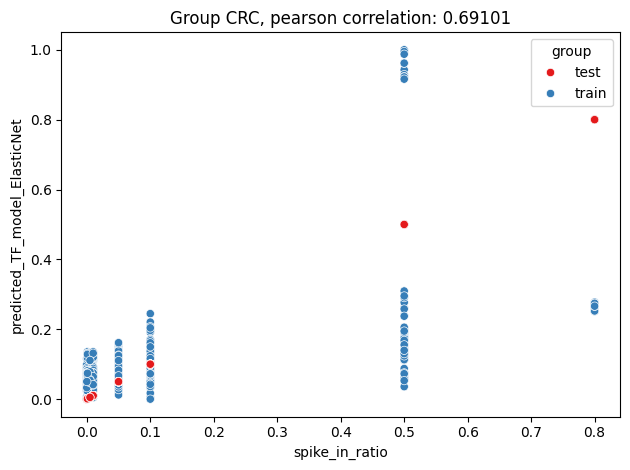

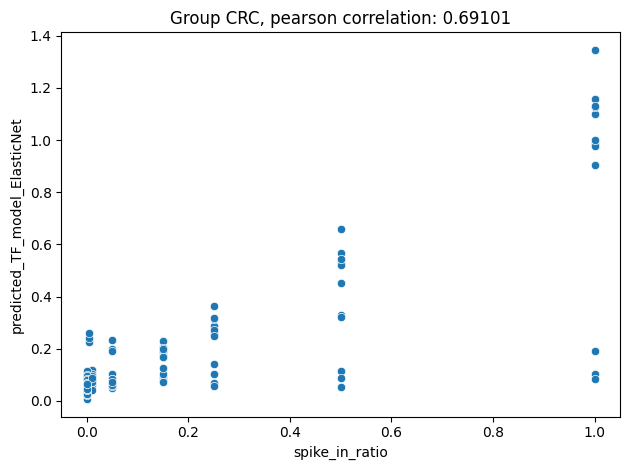

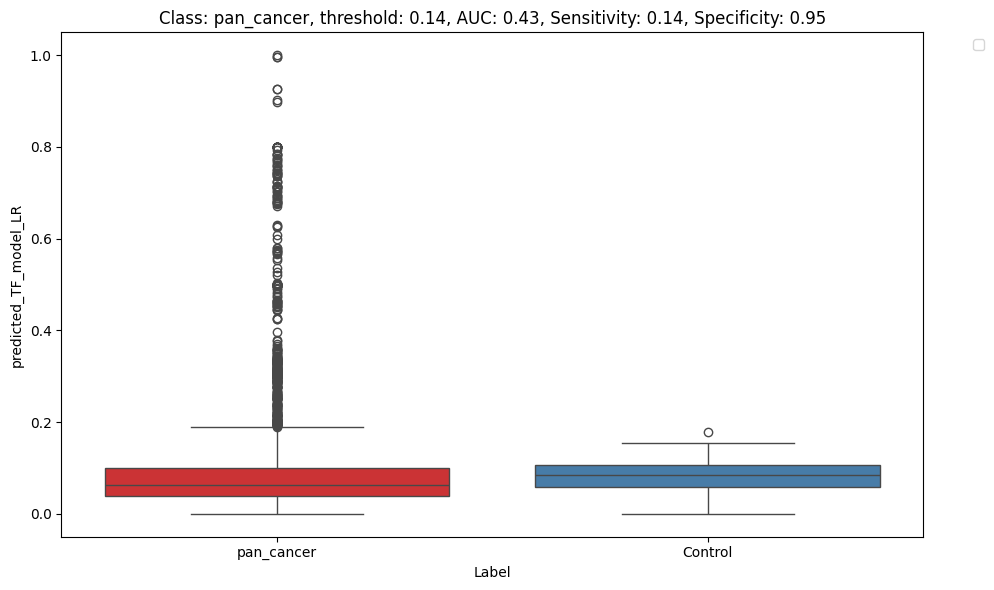

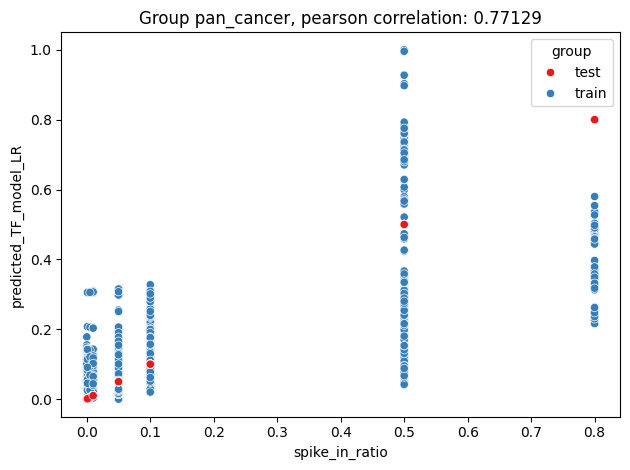

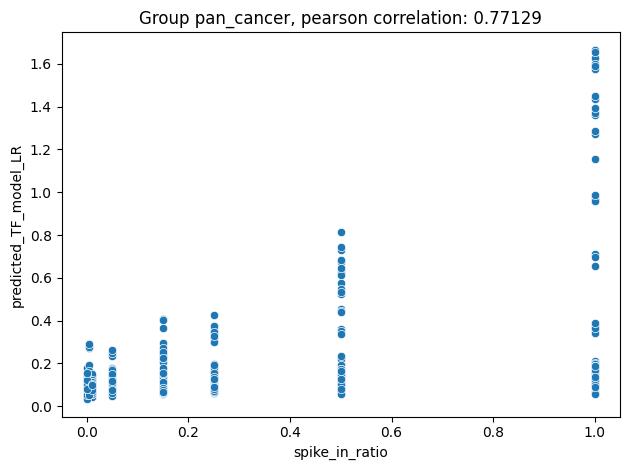

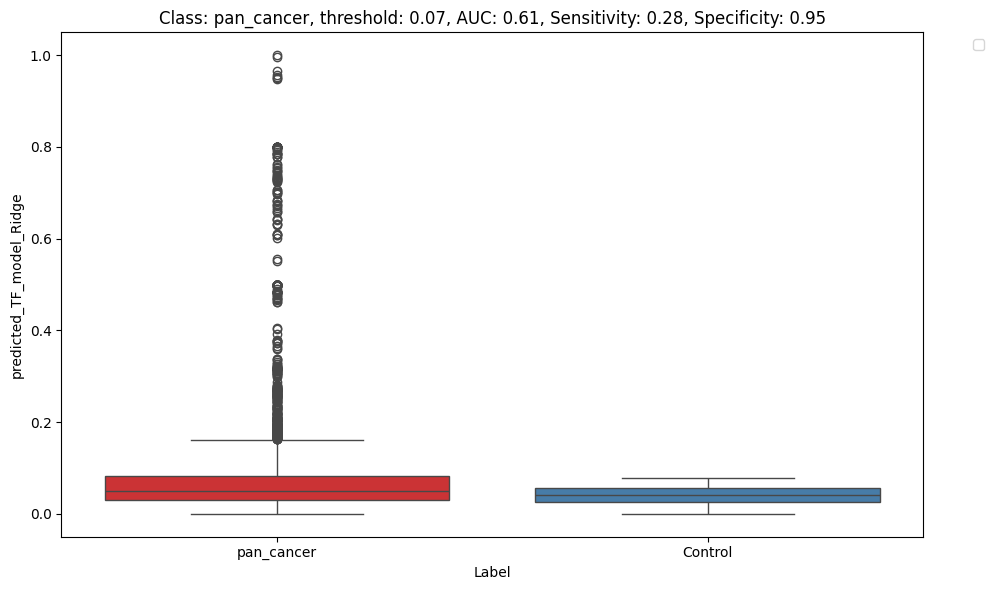

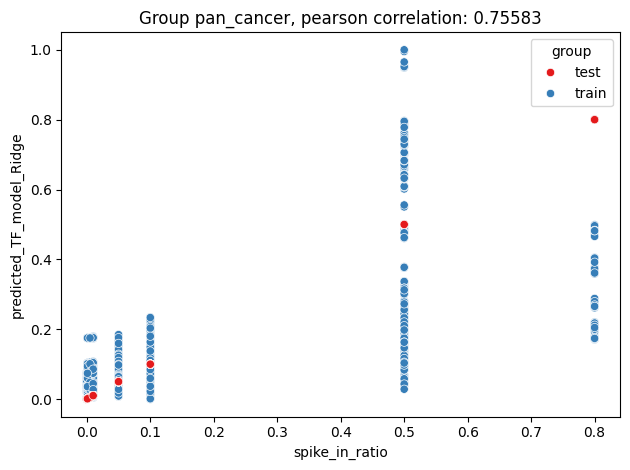

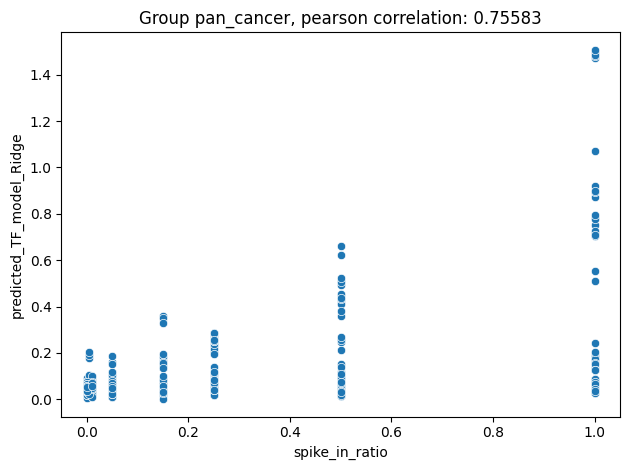

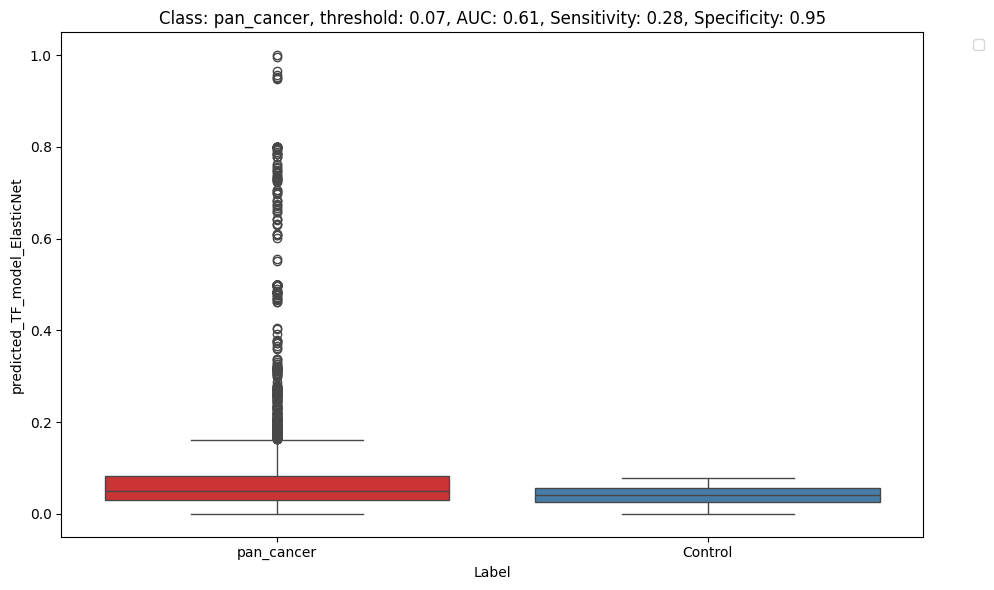

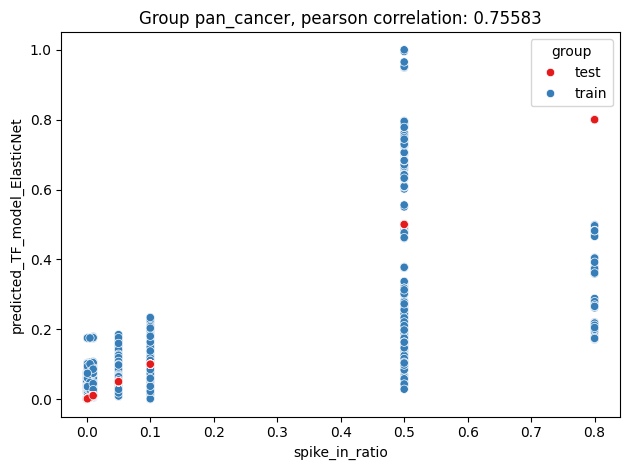

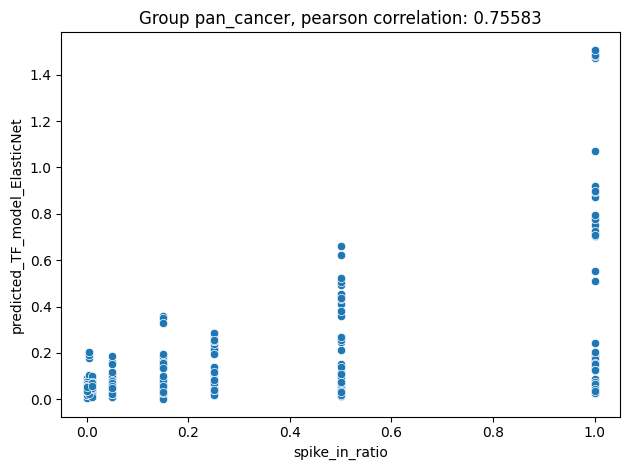

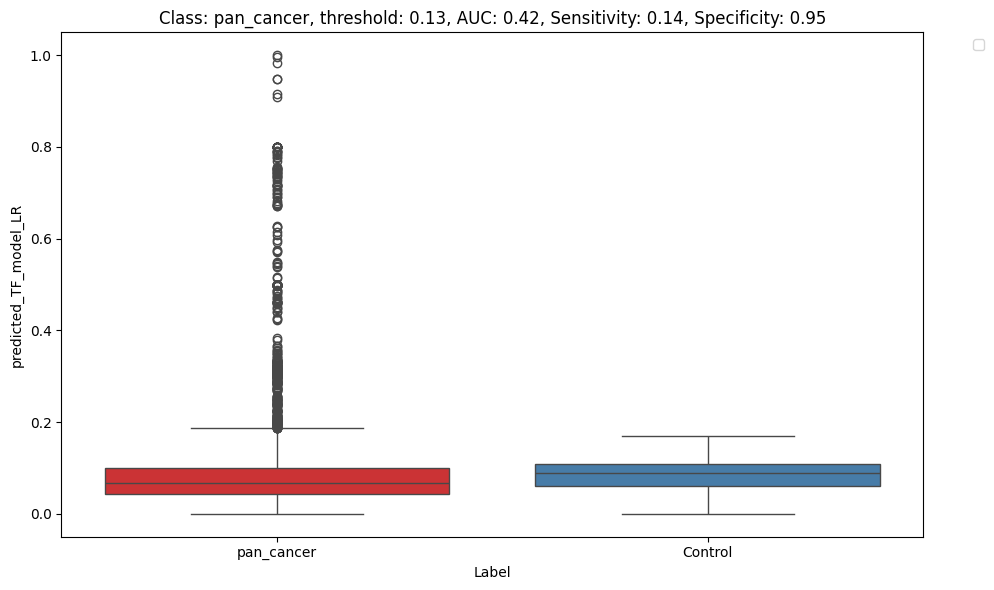

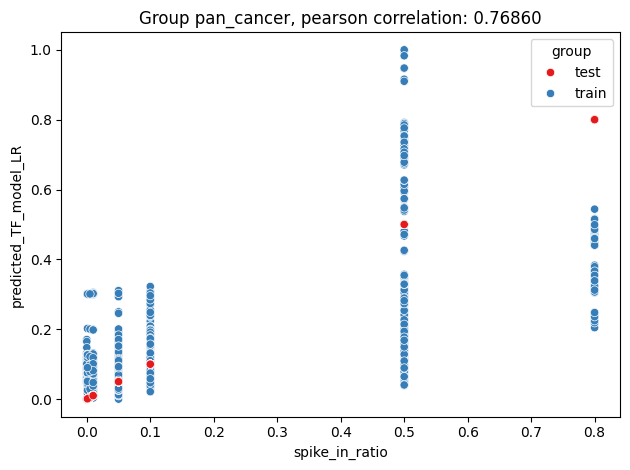

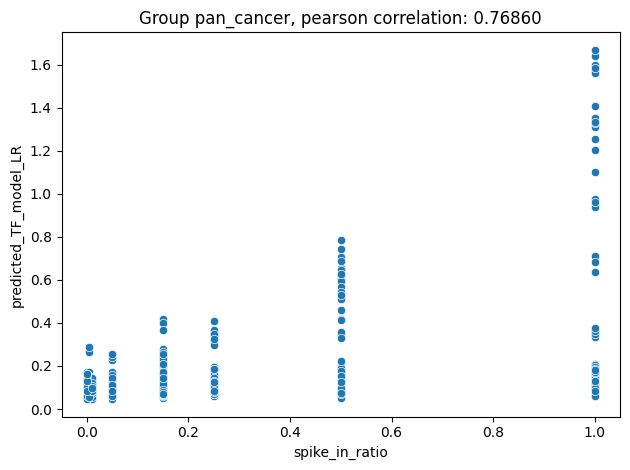

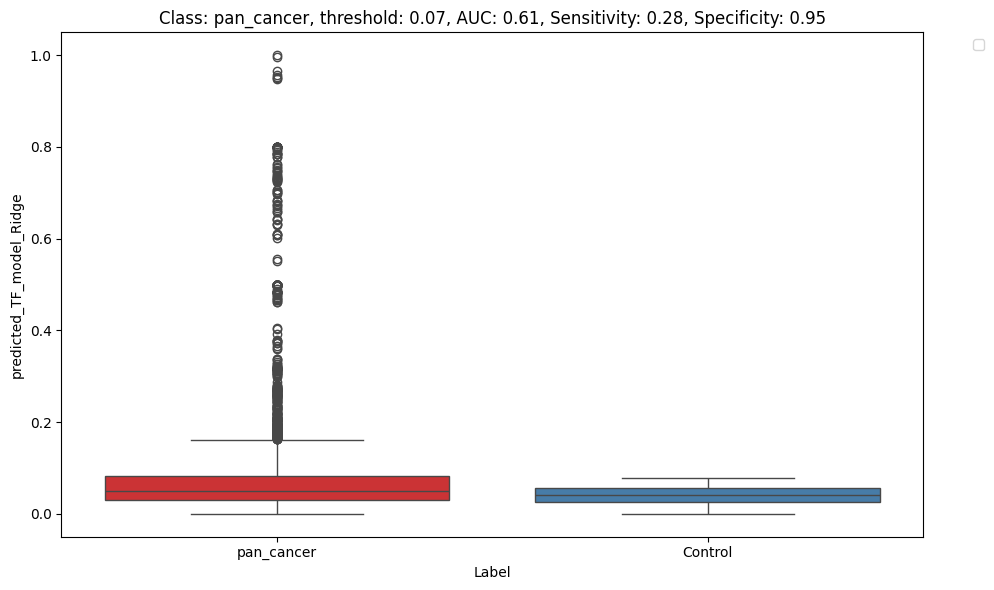

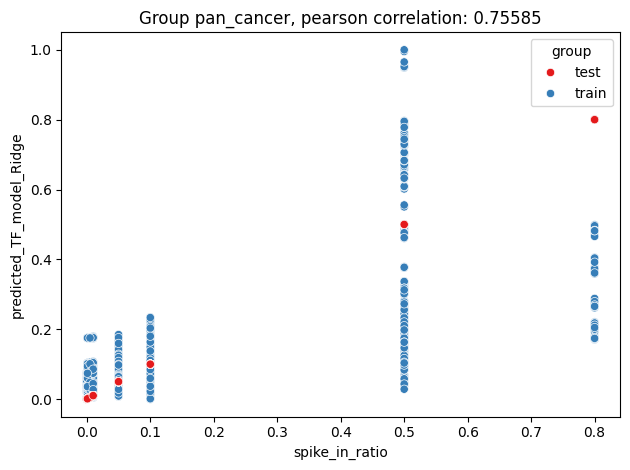

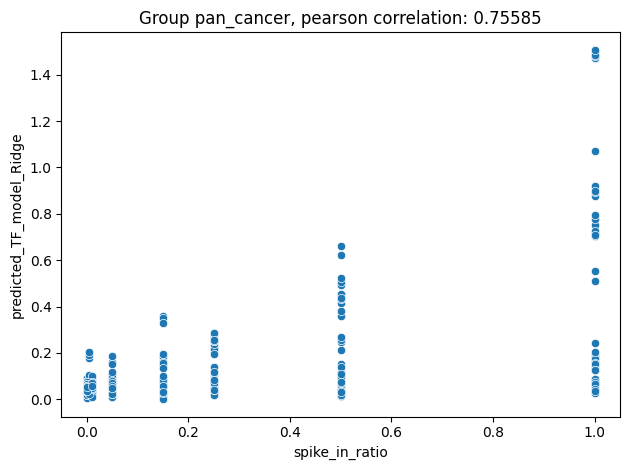

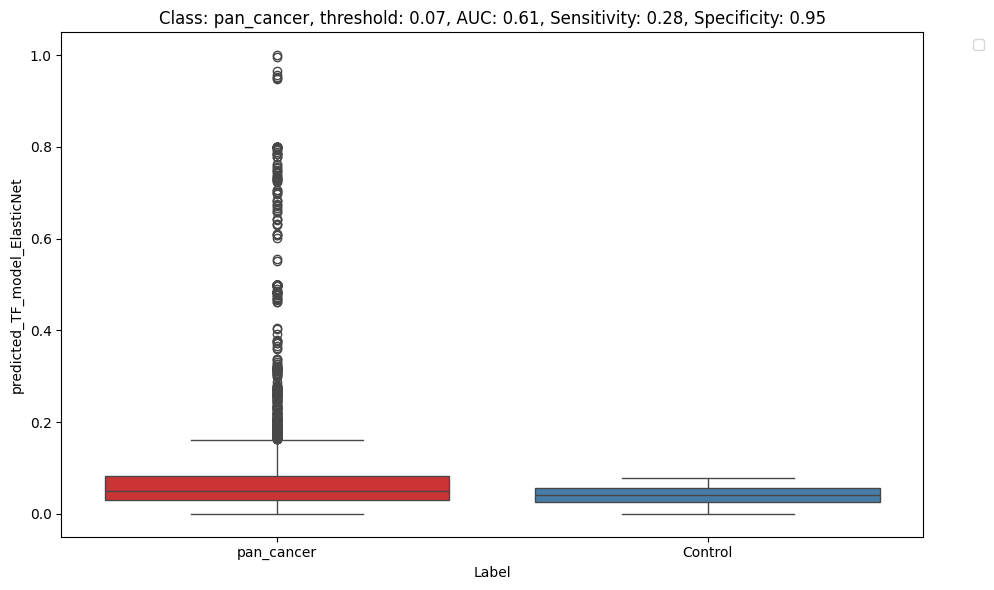

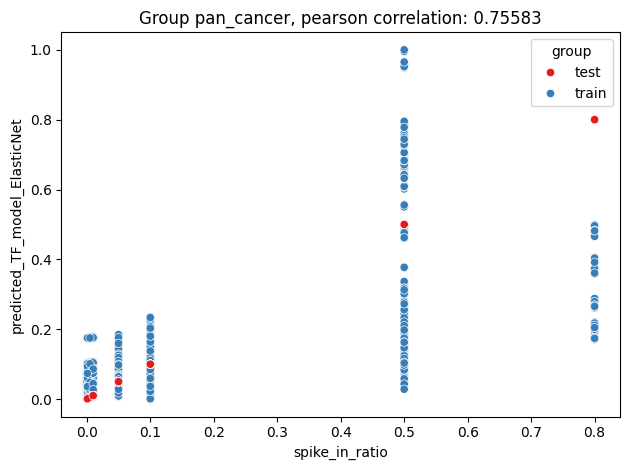

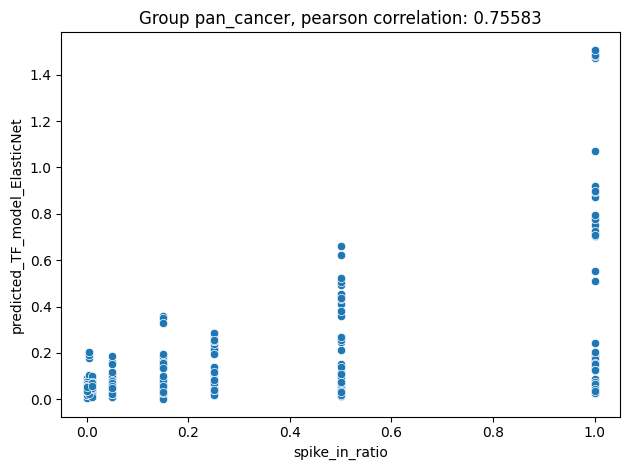

In [1]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
import argparse
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

from dataset_paths import *

warnings.filterwarnings('ignore')

output_version = "20241229"
outdir = "/media/hieunguyen/HNSD_mini/outdir"
dataset_name = "SPIKE_IN"
mode = "all"
PROJECT = "combine_ctcandi_ichorcna"

# input_cancer_class = "Liver"
# selected_candi_features = "ratio_raw"
summarydf = pd.DataFrame()

for input_cancer_class in ["Liver", "Lung", "Breast", "CRC", "pan_cancer"]:
    for selected_candi_features in ["ratio_raw", "ratio_in_read"]:
        input_features = ["ichorCNA", selected_candi_features] 

        path_to_main_output = os.path.join(outdir, PROJECT, output_version, dataset_name)
        path_to_07_output = os.path.join(path_to_main_output, f"07_output_{mode}", input_cancer_class)
        path_to_08_output = os.path.join(path_to_main_output, f"08_output_{mode}", input_cancer_class)
        path_to_10_output = os.path.join(path_to_main_output, f"10_output_{mode}", input_cancer_class, f"feature_{selected_candi_features}")
        path_to_save_models = os.path.join(path_to_10_output, "model_files")
        os.system(f"mkdir -p {path_to_10_output}")
        os.system(f"mkdir -p {path_to_save_models}")

        fulldf = pd.read_csv(os.path.join(path_to_08_output, "feature.csv"), index_col = [0])

        if input_cancer_class == "pan_cancer":
            fulldf["Label"] = fulldf["Label"].apply(lambda x: "pan_cancer" if x != "Control" else "Control")
        else:
            fulldf = fulldf[fulldf["Label"].isin(["Control", input_cancer_class])]

        validationdf = pd.read_csv(os.path.join(outdir, PROJECT, output_version, "VALIDATION", 
                                                f"08_output_{mode}", input_cancer_class, "feature.csv"), index_col = [0])
        validationdf = validationdf[validationdf["ichorCNA"].isna() == False]

        validation2df = pd.read_csv(os.path.join(outdir, PROJECT, output_version, "LOD",
                                            f"08_output_{mode}", input_cancer_class, "feature.csv"), index_col = [0])
        validation2df = validation2df[validation2df["ichorCNA"].isna() == False]

        if input_cancer_class == "pan_cancer":
            validation2df["Label"] = validation2df["Label"].apply(lambda x: "pan_cancer" if x != "Control" else "Control")
        else:
            validation2df = validation2df[validation2df["Label"].isin(["Control", input_cancer_class])]
            
        X_validationdf = validationdf[input_features].to_numpy()
        X_validationdf2 = validation2df[input_features].to_numpy()

        fulldf = pd.concat([fulldf, validation2df[validation2df["Label"] == "Control"]], axis = 0)
        fulldf = fulldf[fulldf["ichorCNA"].isna() == False]
        all_models = dict()

        # Split the data into training and testing sets
        dftrain, dftest = train_test_split(fulldf, test_size=0.2, random_state=42)

        # Define the features and target variable
        X_train = dftrain[input_features]
        y_train = dftrain["spike_in_ratio"]
        X_test = dftest[input_features]
        y_test = dftest["spike_in_ratio"]

        # Initialize and train the regression model, fit LR with intercept
        if os.path.isfile(os.path.join(path_to_save_models, "LR.pkl")) == False:
            model = LinearRegression(fit_intercept = True)
            model.fit(X_train, y_train)

            all_models["LR"] = model
            pickle.dump(model, open(os.path.join(path_to_save_models, "LR.pkl"), "wb"))
        else:
            lr_grid = pickle.load(open(os.path.join(path_to_save_models, "LR.pkl"), "rb"))
            all_models["LR"] = lr_grid
        # Define the models
        ridge = Ridge()
        lasso = Lasso()
        elasticnet = ElasticNet()

        # Define the parameter grids
        ridge_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000], 
                        "fit_intercept": [True, False]}
        lasso_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000],
                        "fit_intercept": [True, False]}

        alpha_values = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
        l1_ratios = np.linspace(0, 1, 11) 

        elasticnet_params = {'alpha': alpha_values, 'l1_ratio': l1_ratios}

        # Perform grid search for Ridge
        if os.path.isfile(os.path.join(path_to_save_models, "Ridge.pkl")) == False:
            ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
            ridge_grid.fit(X_train, y_train)
            if ridge_grid.best_estimator_.coef_[0] != 0:
                all_models["Ridge"] = ridge_grid
                pickle.dump(ridge_grid, open(os.path.join(path_to_save_models, "Ridge.pkl"), "wb"))
        else:
            ridge_grid = pickle.load(open(os.path.join(path_to_save_models, "Ridge.pkl"), "rb"))
            all_models["Ridge"] = ridge_grid
        # Perform grid search for Lasso
        if os.path.isfile(os.path.join(path_to_save_models, "Lasso.pkl")) == False:
            lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
            lasso_grid.fit(X_train, y_train)
            if lasso_grid.best_estimator_.coef_[0] != 0:
                all_models["Lasso"] = lasso_grid
                pickle.dump(lasso_grid, open(os.path.join(path_to_save_models, "Lasso.pkl"), "wb"))
        else:
            lasso_grid = pickle.load(open(os.path.join(path_to_save_models, "Lasso.pkl"), "rb"))
            all_models["Lasso"] = lasso_grid
        # Perform grid search for ElasticNet
        if os.path.isfile(os.path.join(path_to_save_models, "ElasticNet.pkl")) == False:
            elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='r2')
            elasticnet_grid.fit(X_train, y_train)
            if elasticnet_grid.best_estimator_.coef_[0] != 0:
                all_models["ElasticNet"] = elasticnet_grid
                pickle.dump(elasticnet_grid, open(os.path.join(path_to_save_models, "ElasticNet.pkl"), "wb"))
        else:
            elasticnet_grid = pickle.load(open(os.path.join(path_to_save_models, "ElasticNet.pkl"), "rb"))
            all_models["ElasticNet"] = elasticnet_grid

        for i in all_models.keys():
            # Make predictions
            y_pred_train = all_models[i].predict(X_train)
            mse_train = mean_squared_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)
            # Scale the predictions to 0-1 range
            tf_min = y_pred_train.min()
            tf_max = y_pred_train.max()

            y_pred = all_models[i].predict(X_test)
            y_pred_train = (y_pred_train - tf_min)/(tf_max - tf_min)
            y_pred = (y_pred - tf_min) / (tf_max -tf_min)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            dftrain[f"predicted_TF_model_{i}"] = [0 if item < 0 else item for item in y_pred_train]
            dftest[f"predicted_TF_model_{i}"] = [0 if item < 0 else item for item in y_test]
            dftrain["group"] = "train"
            dftest["group"] = "test"

            resdf = pd.concat([dftrain, dftest], axis = 0)
            resdf['Label'] = pd.Categorical(resdf['Label'], categories=[input_cancer_class, "Control"])
            resdf['group'] = pd.Categorical(resdf['group'], categories=["test", "train"])

            fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(resdf['Label'].apply(lambda x: 1 if x == input_cancer_class else 0), resdf[f"predicted_TF_model_{i}"])
            num_cancer = resdf[resdf["Label"] == input_cancer_class].shape[0]
            num_control = resdf[resdf["Label"] != input_cancer_class].shape[0]

            aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
            aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

            lod_thres = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
            lod_spec = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
            lod_sen = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

            # Calculate the AUC
            roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
            plt.figure(figsize=(10, 6))
            sns.boxplot(data=resdf, x="Label", y=f"predicted_TF_model_{i}", hue="Label", palette = "Set1")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.title(f"Class: {input_cancer_class}, threshold: {lod_thres:.2f}, AUC: {roc_auc:.2f}, Sensitivity: {lod_sen:.2f}, Specificity: {lod_spec:.2f}")
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_10_output, f"Prediction_{selected_candi_features}_model_{i}_SPIKE_IN_data.svg"), format='svg')
            plt.show()

            import scipy
            sns.scatterplot(data = resdf, x = "spike_in_ratio", y = f"predicted_TF_model_{i}", hue = "group", palette = "Set1")
            pearson_corr = scipy.stats.pearsonr(resdf[f"predicted_TF_model_{i}"], resdf["spike_in_ratio"])[0]
            plt.title(f"Group {input_cancer_class}, pearson correlation: {pearson_corr:.5f}")
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_10_output, f"Correlation_{selected_candi_features}_model_{i}_predictedTF_SPIKE_IN_data.svg"), format='svg')
            plt.show()

            y_pred_validation1 = all_models[i].predict(X_validationdf)
            y_pred_validation1 = (y_pred_validation1 - tf_min) / (tf_max -tf_min)
            y_pred_validation2 = all_models[i].predict(X_validationdf2)
            y_pred_validation2 = (y_pred_validation2 - tf_min) / (tf_max -tf_min)

            validationdf[f"predicted_TF_model_{i}"] = y_pred_validation1
            validation2df[f"predicted_TF_model_{i}"] = y_pred_validation2

            sns.scatterplot(data = validation2df, x = "spike_in_ratio", y = f"predicted_TF_model_{i}", palette = "Set1")
            pearson_corr2 = scipy.stats.pearsonr(validation2df[f"predicted_TF_model_{i}"], validation2df["spike_in_ratio"])[0]
            plt.title(f"Group {input_cancer_class}, pearson correlation: {pearson_corr:.5f}")
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_10_output, f"Correlation_{selected_candi_features}_model_{i}_predictedTF_LOD_data.svg"), format='svg')
            plt.show()
            tmp = pd.DataFrame(
                {
                "Candi feature": [selected_candi_features],
                "Mode": [mode],
                "Class": [input_cancer_class],
                "Model": [i], 
                "AUC_LOD": [roc_auc], 
                "Sens (LOD)": [lod_sen],
                "Spec (LOD)": [lod_spec], 
                "Pearson corr (LOD)": [pearson_corr],
                "Threshold LOD": [lod_thres],
                "Pearson corr. SPIKE-IN": [pearson_corr2]
                })

            summarydf = pd.concat([summarydf, tmp], axis = 0)

        validationdf.to_excel( os.path.join(path_to_10_output, "validation_data.xlsx"))
        validation2df.to_excel( os.path.join(path_to_10_output, "validation_LOD_data.xlsx"))

highlight_features = ["Pearson corr. SPIKE-IN", "Pearson corr (LOD)"]

summarydf.reset_index().drop("index", axis = 1).style.background_gradient(subset = highlight_features).to_excel(os.path.join(os.path.join(outdir, 
                                                                                                                                          PROJECT, 
                                                                                                                                          output_version, 
                                                                                                                                          dataset_name, 
                                                                                                                                          f"10_output_{mode}", 
                                                                                                                                          "summary_all_models.xlsx")))